# Readmition predictor project - EDA
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

# Working with data_transformer pipeline

start the code from 0. setup! 

# 0. setup

In [1]:
import data_transformers as dt
from sklearn.pipeline import Pipeline
from copy import deepcopy

In [2]:
import pandas as pd
import numpy as np
from paths import DATA_PATH
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class SetEncounter(BaseEstimator, TransformerMixin):
    def __init__(self, ):

        self.name = "SetEncounter"
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['encounter'] = 'None'
        X.loc[(df.A1Cresult == '>7') | (X.A1Cresult == '>8'), 'encounter'] = '7_No'
        X.loc[((df.A1Cresult == '>7') | (X.A1Cresult == '>8')) & (X.change == 'Ch'), 'encounter'] = '7_Ch'
        X.loc[df.A1Cresult == 'Norm', 'encounter'] = 'Norm'
        X.drop(columns=['A1Cresult', 'change'], inplace=True)
        return X
    

In [3]:
import os
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm
# Force printing all the variables in each cell, not just the last one: 
InteractiveShell.ast_node_interactivity = "all"


# plot count with percent
def plot_categorical_with_percent(data, column, **kwargs):
    total_count = len(data[column])
    ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
    plt.title(f'Count Plot for {column}')
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.01 * total_count  # Adjust the vertical position of the text
        ax.annotate(percentage, (x, y), ha='center')
    return ax



def plot_dual_plot(x, data, hue, palette):
    # Calculate the order of bars by counts
    order = data[x].value_counts().index

    # Create subplots
    f, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot countplot on the first subplot
    sns.countplot(x=x, data=data, hue=hue, order=order, palette=palette, ax=axes[0])

    # Plot percentplot on the second subplot
    prop_df = (data[x]
               .groupby(data[hue])
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

    g = sns.barplot(x=x, y='percentage', hue=hue, data=prop_df, ax=axes[1], palette=palette, order=order)

    # Place legend beneath both plots
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=len(pd.unique(data[x])))
    axes[1].get_legend().remove()  # Remove legend from the second plot

    # Add percentage labels to the bars in the countplot
    for p in g.patches:
        txt = str(np.round(p.get_height(), decimals=2)) + '%'
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = p.get_height()
        g.annotate(txt, (txt_x, txt_y), ha='center', va='bottom')

    # Show the plots
    plt.show()

# 0.1 read the data 

The dataset covers 10 years (1998-2008) of diabetes patient data gathered from 130 US hospitals having 70,000 distinct patients. Every record was labelled as to whether the patient was readmitted within 30 days, readmitted after 30 days, or not readmitted at all. 


"In this project, we are using the data_transformers library to manipulate our datafram

to save all data changes we are using prop_setter that log our changes."

In [4]:
prop_setter = dt.PropertySetter()

## List of features and their descriptions in the initial dataset (the dataset is also available at the website of Data Mining and Biomedical Informatics Lab at VCU

https://www.hindawi.com/journals/bmri/2014/781670/tab1/


The data contains sorten coloumns that uses ID:

ID list:
admission_type_id	
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
	
discharge_dispoescription
1	Discharged to home
2	Discharged/transferred to another short term hospital
3	Discharged/transferred to SNF
4	Discharged/transferred to ICF
5	Discharged/transferred to another type of inpatient care institution
6	Discharged/transferred to home with home health service
7	Left AMA
8	Discharged/transferred to home under care of Home IV provider
9	Admitted as an inpatient to this hospital
10	Neonate discharged to another hospital for neonatal aftercare
11	Expired
12	Still patient or expected to return for outpatient services
13	Hospice / home
14	Hospice / medical facility
15	Discharged/transferred within this institution to Medicare approved swing bed
16	Discharged/transferred/referred another institution for outpatient services
17	Discharged/transferred/referred to this institution for outpatient services
18	NULL
19	Expired at home. Medicaid only, hospice.
20	Expired in a medical facility. Medicaid only, hospice.
21	Expired, place unknown. Medicaid only, hospice.
22	Discharged/transferred to another rehab fac including rehab units of a hospital .
23	Discharged/transferred to a long term care hospital.
24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25	Not Mapped
26	Unknown/Invalid
30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27	Discharged/transferred to a federal health care facility.
28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29	Discharged/transferred to a Critical Access Hospital (CAH).
	
admission_source_id	description
1	 Physician Referral
2	Clinic Referral
3	HMO Referral
4	Transfer from a hospital
5	 Transfer from a Skilled Nursing Facility (SNF)
6	 Transfer from another health care facility
7	 Emergency Room
8	 Court/Law Enforcement
9	 Not Available
10	 Transfer from critial access hospital
11	Normal Delivery
12	 Premature Delivery
13	 Sick Baby
14	 Extramural Birth
15	Not Available
17	NULL
18	 Transfer From Another Home Health Agency
19	Readmission to Same Home Health Agency
20	 Not Mapped
21	Unknown/Invalid
22	 Transfer from hospital inpt/same fac reslt in a sep claim
23	 Born inside this hospital
24	 Born outside this hospital
25	 Transfer from Ambulatory Surgery Center
26	Transfer from Hospice



In [5]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col=0)

In [102]:
prossesed_data = pd.read_csv('C://Users/dekel/Desktop/ml_project/240418/ml-2024/data/prepped/prepped_data 0c84a8 NonStandardized.csv', index_col=0)

## 1.1 Take a Quick Look at the Data Structure

In [6]:
df.head()
df.info()

patient_nbr             race  gender      age weight  \
encounter_id                                                         
2278392           8222157        Caucasian  Female   [0-10)      ?   
149190           55629189        Caucasian  Female  [10-20)      ?   
64410            86047875  AfricanAmerican  Female  [20-30)      ?   
500364           82442376        Caucasian    Male  [30-40)      ?   
16680            42519267        Caucasian    Male  [40-50)      ?   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   

              admission_source_id  time_in_hospital payer_code  ...  \
encounter_id                                                    ...   
2278392                         1                 1          ?  ...   
149190                          7                 3          ?  ...   
64410                           7                 2          ?  ...   
500364                          7                 2          ?  ...   
16680                           7                 1          ?  ...   

             citoglipton  insulin  glyburide-metformin  glipizide-metformin  \
encounter_id                                                                  
2278392               No       No                   No                   No   
149190                No       Up                   No                   No   
64410                 No       No                   No                   No   
500364                No       Up                   No                   No   
16680                 No   Steady                   No                   No   

              glimepiride-pioglitazone  metformin-rosiglitazone  \
encounter_id                                                      
2278392                             No                       No   
149190                              No                       No   
64410                               No                       No   
500364                              No                       No   
16680                               No                       No   

              metformin-pioglitazone change diabetesMed readmitted  
encounter_id                                                        
2278392                           No     No          No         NO  
149190                            No     Ch         Yes        >30  
64410                             No     No         Yes         NO  
500364                            No     Ch         Yes         NO  
16680                             No     Ch         Yes         NO  

[5 rows x 49 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

looks like missing values are marked as "?" 
we are changing it to nan so we can use the df.info() function and see the real non-null count

In [7]:
replace_value_to_nan = dt.ReplaceValueToNan(value='?')
df = replace_value_to_nan.fit_transform(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

# 0.2 label

We are going to use 'readmission' as our label in a binary classification problem. First, we need to understand how the 'readmitted' variable is distributed.


C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

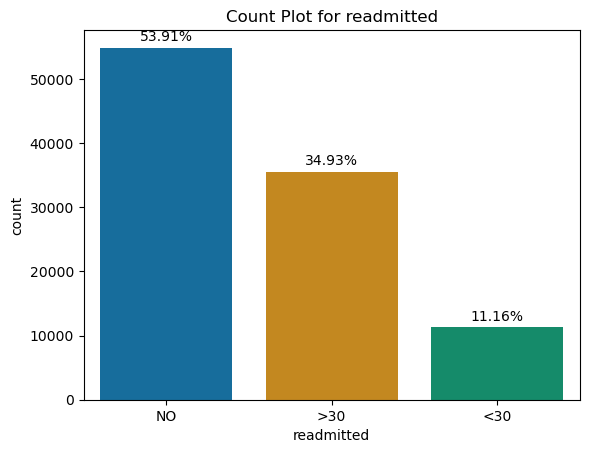

In [9]:
plot_categorical_with_percent(df, column="readmitted", palette="colorblind", hue="readmitted")

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

In [10]:
lookup_lable = {
            'YES': ['<30'],
            'NO': ['>30', 'NO']}
change_label = dt.CategoryReducer('readmitted', lookup_lable)
change_label.prop_setter = prop_setter
change_label = change_label._fit(df)
df = change_label.transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

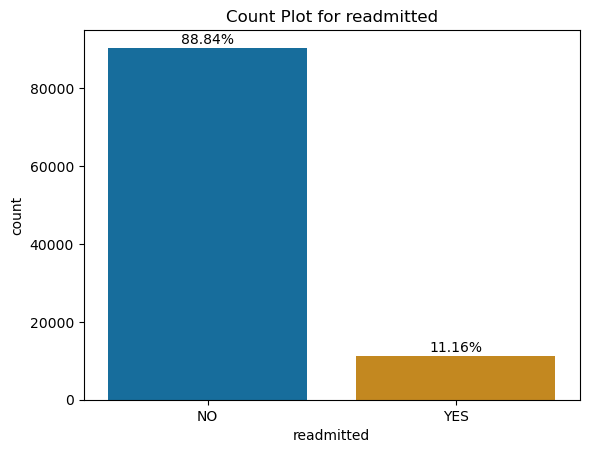

In [11]:
plot_categorical_with_percent(df, column="readmitted", palette="colorblind", hue="readmitted")

## Approximately 11% of the population experiences rehospitalization, indicating an imbalanced classification scenario.

Upon examining the 'IDs_mapping.csv' file provided by UCI, it is evident that IDs 11, 13, 14, 19, 20, and 21 are associated with death or hospice situations. Consequently, it is advisable to exclude these samples from the predictive model, as they do not apply to readmission scenarios.

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

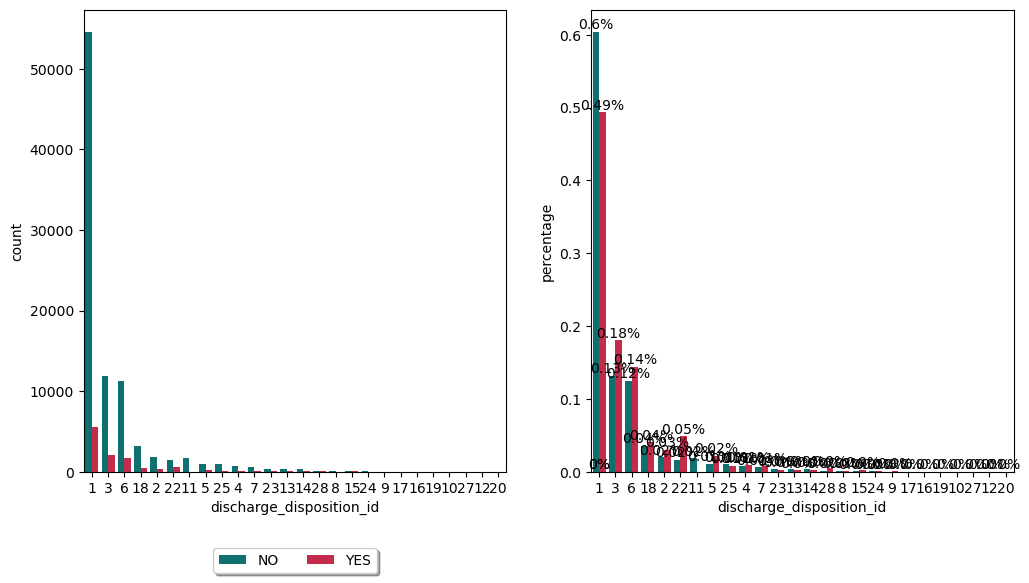

In [12]:
# removing discharge: 11, 13, 14, 19, 20, and 21
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

hue = 'readmitted'
data=df
x = 'discharge_disposition_id'
palette = ["teal", "crimson"]

# sns.histplot( x=feature, data=df,  **style).set_title(f'feature: {feature}')
plot_dual_plot(x=x, data=data, hue=hue, palette=palette)

In [13]:
remove_rows = dt.RowRemoverByFeatureValue(feature='discharge_disposition_id', exclude_vals=[11,13,14,19,20,21])
df = remove_rows.fit_transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

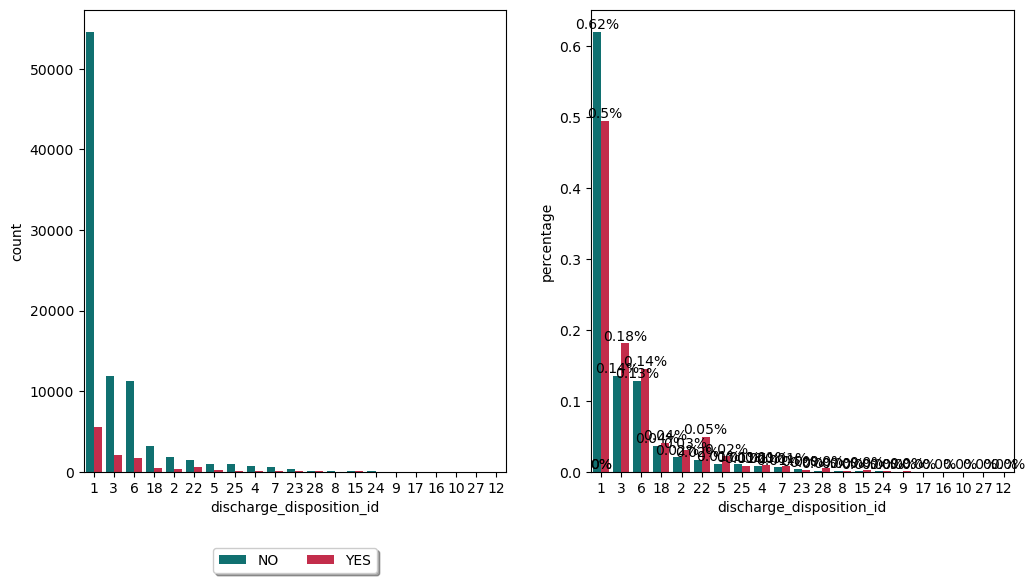

In [14]:
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

hue = 'readmitted'
data=df
x = 'discharge_disposition_id'
palette = ["teal", "crimson"]

# sns.histplot( x=feature, data=df,  **style).set_title(f'feature: {feature}')
plot_dual_plot(x=x, data=data, hue=hue, palette=palette)

# 0.3  drop duplicates by patient_nbr:

we remove patients with more than one addmition


In [15]:
# remove_duplicates = dt.RowRemoverByDuplicates(feature='patient_nbr')
# df = remove_duplicates.transform(df)

# 1 deals with missing and bios values
We want to know which columns have missing values:

In [16]:
#  to evaluate how the missing value afect our data we want to see in what column we have 
# missing value and waht is the ratio

def calc_missing_percent(df):
    ''' calculate the number of nan values in coloumns with missing values 
     returns df with missing values info
     '''
    # Extract column-wise missing values
    missing_values = df.isnull().sum()
    # Calculate percentage of missing values for each column
    missing_percentage = missing_values[missing_values>0]/len(df) *100  
    return pd.DataFrame(missing_percentage, columns=['Percent of missing'])

# Print the DataFrame
calc_missing_percent(df)

Percent of missing
race                         2.248774
weight                      96.854333
payer_code                  39.658557
medical_specialty           48.937520
diag_1                       0.020132
diag_2                       0.358354
diag_3                       1.428384
max_glu_serum               94.813928
A1Cresult                   83.054669

The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features are weight (97% values missing), payer code (40%), and medical specialty (49%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code is removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.
In addition we added value 'missing' in 'race'column.
We will deel with the diag columns later 

In [17]:
df.drop(columns=['weight', 'payer_code'], inplace=True)
calc_missing_percent(df)

Percent of missing
race                         2.248774
medical_specialty           48.937520
diag_1                       0.020132
diag_2                       0.358354
diag_3                       1.428384
max_glu_serum               94.813928
A1Cresult                   83.054669

## 1.1 Remove Features with Low Variance

In some cases, dataframes may contain features biased towards one particular value. To gain a better understanding of our data, we would like to examine the ratio of the most common value for each feature. Therefore, we will plot the ratio of the most common value for all feature."

In [18]:
def unique_values_and_ratio(df):
    unique_counts = df.nunique()  # Number of unique values in each column
    
    most_common_ratios = ((df == df.mode().values).sum()/len(df))*100  # Ratio of most common value
   
    return  pd.DataFrame({"Unique Values": unique_counts, "Most Common Ratio": most_common_ratios})

unique = unique_values_and_ratio(df)
unique['above_95'] = unique['Most Common Ratio']>=95
unique[unique['above_95'] == True]

Unique Values  Most Common Ratio  above_95
repaglinide                           4          98.471961      True
nateglinide                           4          99.306443      True
chlorpropamide                        4          99.914438      True
acetohexamide                         2          99.998993      True
tolbutamide                           2          99.978861      True
acarbose                              4          99.692983      True
miglitol                              4          99.961749      True
troglitazone                          2          99.996980      True
tolazamide                            3          99.960742      True
examide                               1         100.000000      True
citoglipton                           1         100.000000      True
glyburide-metformin                   4          99.297384      True
glipizide-metformin                   2          99.986914      True
glimepiride-pioglitazone              2          99.998993      True
metformin-rosiglitazone               2          99.997987      True
metformin-pioglitazone                2          99.998993      True

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Number of high bias features')

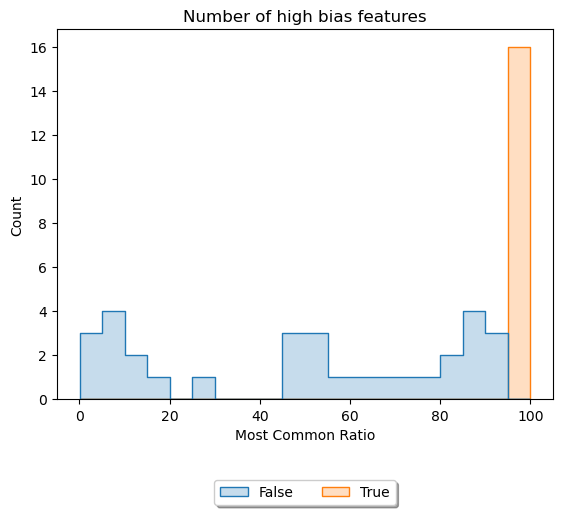

In [19]:
ax =sns.histplot(data=unique, x='Most Common Ratio', element='step',hue='above_95', bins=20)
sns.move_legend(
        ax, "upper center",
        bbox_to_anchor=(0.5, -0.2), ncol=4, title=None, fancybox=True, shadow=True)
ax.set_title(label='Number of high bias features')

16 features have a high bias to one value,
Let's first understand what the feature stands for, and what  the values are:

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: repaglinide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: nateglinide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: chlorpropamide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: acetohexamide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: tolbutamide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: acarbose')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: miglitol')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: troglitazone')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: tolazamide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: examide')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: citoglipton')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: glyburide-metformin')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: glipizide-metformin')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: glimepiride-pioglitazone')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: metformin-rosiglitazone')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: metformin-pioglitazone')

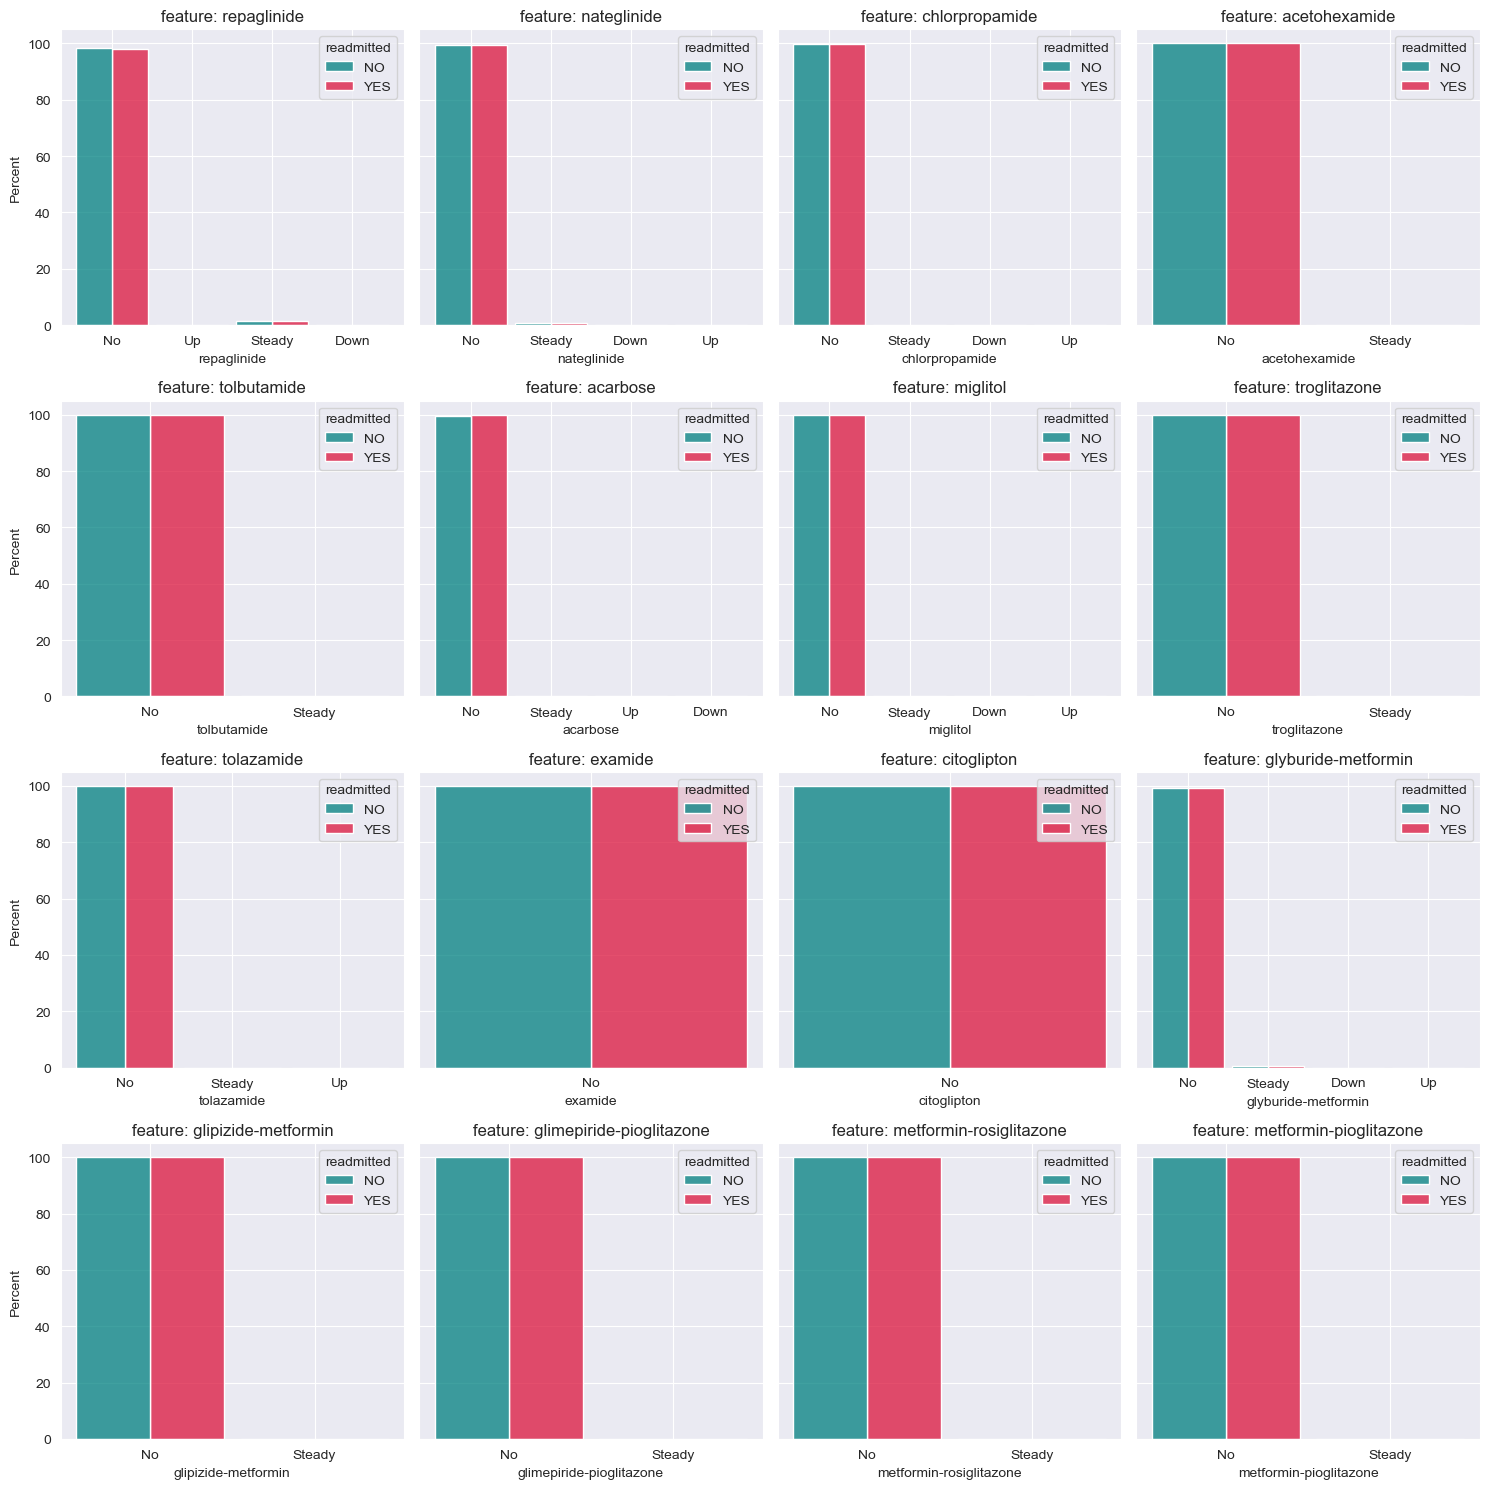

In [20]:
sns.set_style('darkgrid')
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

features_with_low_bias = unique[unique['above_95'] == True].index
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharey=True)
axes = axes.flatten()
for i, feature in enumerate(features_with_low_bias):
    sns.histplot( x=feature, data=df, ax=axes[i],  **style).set_title(f'feature: {feature}')

fig.tight_layout()
plt.show()

To understand the health-relevant of these features lets go over them and see if it is important and if there is a way to group them.

1. Repaglinide: A medication used to treat type 2 diabetes by helping the pancreas produce insulin.
2. Nateglinide: r medication for type 2 diabetes,that  stimulaesg insulin release from pancreatic beta cells.
3. Chlorpropamide: An oral antidiabetic drug that stimulates insulin release from pancreatic beta cells.
4. Acetohexamide: A sulfonylurea medication used to manage type 2 diabetes by stimulating insulin secretion.
5. Tolbutamide: A first-generation sulfonylurea drug that increases insulin release from pancreatic beta cells.
6. Acarbose: An alpha-glucosidase inhibitor used to treat type 2 diabetes by slowing carbohydrate digestion.
7. Miglitol: Another alpha-glucosidase inhibitor for type 2 diabetes, reducing postprandial blood glucose le8els.
8. Troglitazone: A former medication for type 2 diabetes, part of the thiazolidinedione class, withdrawn due to safety con9erns.
9. Tolazamide: A sulfonylurea medication that stimulates insulin release, used in managing type 2 di10etes.
10. It is used for the treatment of EDEMA associated with CONGESTIVE HEART FAILURE; CHRONIC RENAL INSUFFICIENCY; and LIVER DISEASES.  c11older.
11. Citoglipton: Not a recognized medication; could be a typo or pla12holder.
12. Glyburide-metformin: A combination medication for type 2 diabetes, containing both glyburide (a sulfonylurea) and 13tformin.
13. Glipizide-metformin: Another combination drug for type 2 diabetes, containing glipizide (a sulfonylurea) and14etformin.
14. Glimepiride-pioglitazone: A combination medication for type 2 diabetes, consisting of glimepiride (a sulfonylurea) and pioglitazone (a thiazol15inedione).
15. Metformin-rosiglitazone: A combination drug for type 2 diabetes, combining metformin (a biguanide) with rosiglitazone (a thiazo16dinedione).
16. Metformin-pioglitazone: A combination medication for type 2 diabetes, including metformin (a biguanide) and pioglitazone (a thiazball are known diabetes 2 drugs
let's look at our data, and see if we can find more diabetes 2 drugs and if we can group them by drug type


In [21]:
# We are using biased data and setting a new threshold of 70
unique['above_70'] = unique['Most Common Ratio']>=70
unique[(unique['above_70'] == True) & (unique['above_95'] != True)].index

Index(['race', 'number_outpatient', 'number_emergency', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'diabetesMed', 'readmitted'],
      dtype='object')

We found more drugs: 'metformin','glimepiride', 'glipizide', 'glyburide', 'pioglitazone','rosiglitazone', 'diabetesMed'

Grouping the drugs by type and function:
- **Biguanides (Insulin Sensitizers)**: Improve insulin sensitivity, predominantly used as first-line therapy for type 2 diabetes.
  - Metformin
  - Glyburide-metformin
  - Glimepiride-pioglitazone
  - Metformin-rosiglitazone

- **Meglitinides (Short-acting Insulin Secretagogues)**: Rapidly stimulate insulin release, particularly beneficial for postprandial glucose control.
  - Repaglinide
  - Nateglinide

- **Sulfonylureas (Insulin Secretagogues)**: Stimulate insulin secretion, effective but may cause hypoglycemia and weight gain.
  - Chlorpropamide
  - Glimepiride
  - Acetohexamide
  - Glipizide
  - Glyburide
  - Tolbutamide

- **Thiazolidinediones (PPARγ Agonists)**: Enhance insulin sensitivity, suitable for insulin-resistant patients; potential cardiovascular concerns.
  - Pioglitazone
  - Rosiglitazone
  - Troglitazone

- **Alpha-glucosidase inhibitors (Carbohydrate Digestion Inhibitors)**: Slow carbohydrate absorption, suitable for controlling postprandial glucose levels, often used adjunctively.
  - Acarbose
  - Miglitol

- **Miscellaneous (Varied Mechanisms)**: Include diverse agents with various mechanisms of action, used when standard therapy is ineffective.
  - Tolazamide
  - Examide
  - Citoglipton
  - Glipizide-metfo
 
new lets see what the distribution looks like:

In [22]:
class DataTransformer(BaseEstimator, TransformerMixin):

    def fit(self, *args):
        return self

    @property
    def name(self):
        name = self.__class__.__name__
        for attr in ['feature', 'method']:
            if hasattr(self, attr):
                name += f"[{getattr(self, attr)}]"
        return name

In [23]:
from itertools import chain
class DataTransformer(BaseEstimator, TransformerMixin):

    def fit(self, *args):
        return self

    @property
    def name(self):
        name = self.__class__.__name__
        for attr in ['feature', 'method']:
            if hasattr(self, attr):
                name += f"[{getattr(self, attr)}]"
        return name

class GroupFeatures(DataTransformer):
    ''' using np.sum(eval(f'df[drugs_dict[key]] {sel.operator} self.group_term'), axis=1) to group features'''

    def __init__(self, features: dict, group_term='No', operator = '!='):
        self.features = features
        self.new_features = features.keys()
        self.old_features = list(chain.from_iterable(features.values()))
        self.group_df = pd.DataFrame()
        self.group_term = group_term
        self.operator = operator


    def fit(self, X):
        for key in self.features.keys():
            self.group_df[key] = np.sum(eval(f'X[drugs_dict[key]] {self.operator} self.group_term'), axis=1) 
                
    def transform(self, X):
        X.drop(columns=self.old_features, inplace=True)
        return pd.concat([X,self.group_df], axis=1)


class SumFeatures(DataTransformer):
    ''''''

    def __init__(self, features: list, new_feature_name,  group_term='0', operator = '>'):
        self.features = features
        self.result = None
        self.new_feature_name = new_feature_name
        self.group_term = group_term
        self.operator = operator

    def fit(self, X):
        if ((self.group_term != None) & (self.operator != None)):
             self.result = np.sum(eval(f'X[self.features] {self.operator} {self.group_term}'), axis=1)
        else:    
            self.result = np.sum(X[self.features], axis=1)
                
    def transform(self, X):
        X[self.new_feature_name] = self.result
        return X

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: biguanides')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: meglitinides')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: sulfonylureas')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: thiazolidinediones')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: alpha-glucosidase inhibitors')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: miscellaneous')

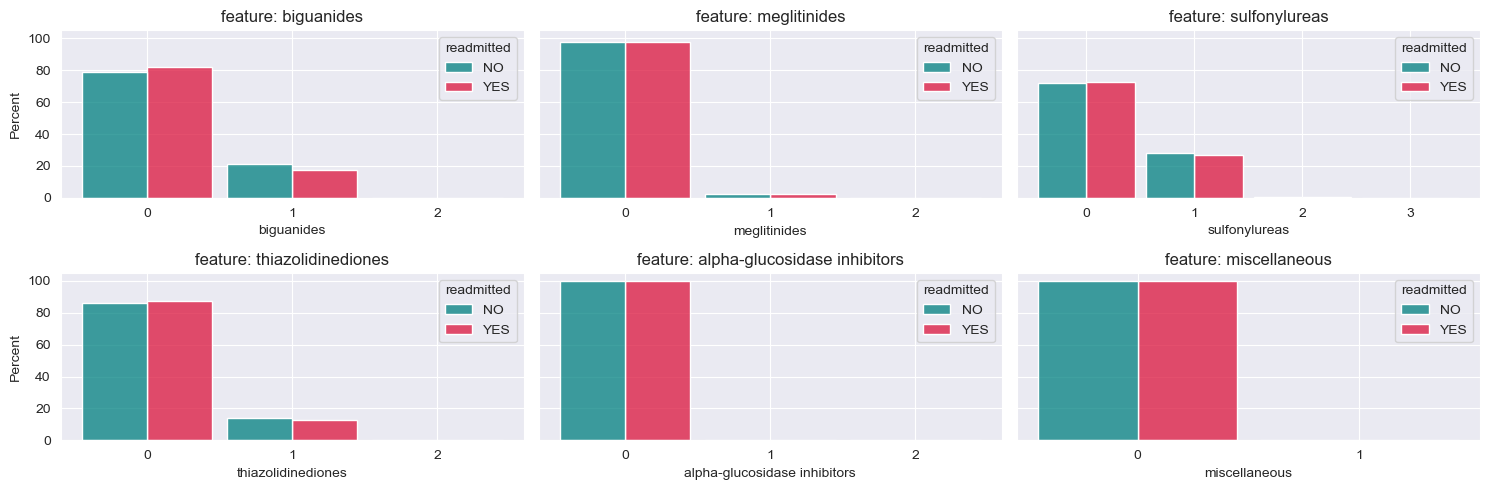

In [24]:
from matplotlib.ticker import MaxNLocator
# we are using GroupFeatures class to create a new dataframe with the unite drugs
drugs_dict = {
    "biguanides": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "meglitinides": ["repaglinide", "nateglinide"],
    "sulfonylureas": ["chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones": ["pioglitazone", "rosiglitazone", "troglitazone"],
    "alpha-glucosidase inhibitors": ["acarbose", "miglitol"],
    "miscellaneous": ["tolazamide", "examide", "citoglipton", "glipizide-metformin", "metformin-pioglitazone"]}

drug_types = list(drugs_dict.keys())
# adding the number of drug types as well, and the number of combinations between families of drugs
drug_df = pd.DataFrame()
for key in drugs_dict.keys():
    drug_df[key] = np.sum(df[drugs_dict[key]] != 'No', axis=1) 
# drug_df['No'] = np.sum(drug_df, axis=1) 

drug_df['number_diabetic_drugs'] = np.sum(drug_df, axis=1) 
drug_df['number_diabetic_famalies'] = np.sum(drug_df[drug_types]>0, axis=1)
drug_df['readmitted'] = df.readmitted

# 1. let's plot the distributions of the number of drugs from the same family patients get and split it by the readmission label, we would like to see if there is the medication type has a significant affect on the readmission.
# 2. Also we whant to see if a pationt gets a combination of different families of diabetic drugs has an effect on readmission

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), sharey=True)
axes = axes.flatten()

for i, key in enumerate(drugs_dict.keys()):
    sns.histplot(data=drug_df.astype('category'), x=key, ax=axes[i], **style).set_title(f'feature: {key}')
    # sns.histplot(data=drug_df[drug_df['readmitted'] != 'readmitted'],element='step', x=key,color='crimson',  ax=axes[i], stat='percent', multiple='dodge').set_title(f'feature: {key}')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()


C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: number_diabetic_famalies')

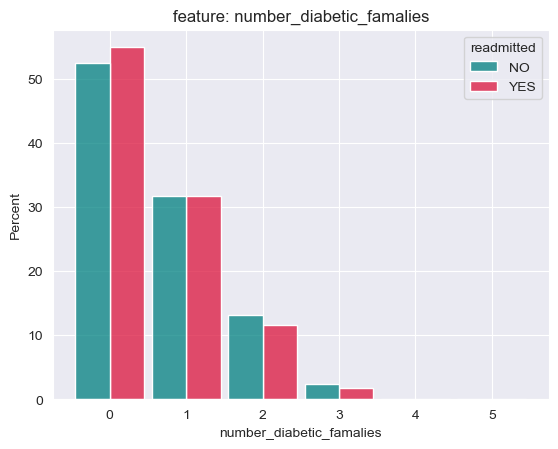

In [25]:
sns.histplot(data=drug_df.astype('category'), x='number_diabetic_famalies', **style).set_title('feature: number_diabetic_famalies')

We see a anty-correlation between the number of drugs from different families and the readmission ratio, patients that got drugs from two families were readmitted less. also we can see that most patiens got up to 3 drug families

We can also see a small effect on the readmission ratio in biguanides, sulfonylureas, and thiazolidinediones. and we can't see any effect on the other groups.`
let's try to regroup the drugs into bigger groups based on the drug type:

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: biguanides_and_related')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: sulfonylureas_and_meglitinides')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: thiazolidinediones_and_miscellaneous')

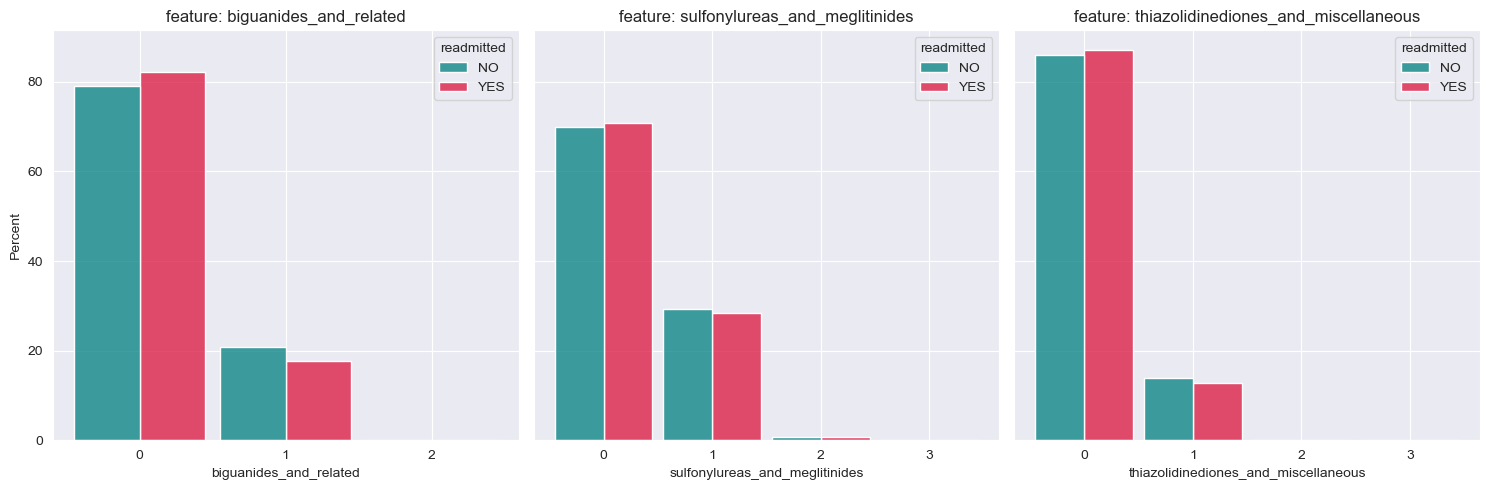

In [26]:
# from matplotlib.ticker import MaxNLocator
drugs_dict = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "examide", "citoglipton", "glipizide-metformin", "metformin-pioglitazone"]
}
drug_types = ['biguanides_and_related', 'sulfonylureas_and_meglitinides', 'thiazolidinediones_and_miscellaneous']
# creating a new dataframe with the new grouping, adding the number of drug types as well, and the number of combinations between families of drugs
drug_df = pd.DataFrame()
for key in drugs_dict.keys():
    drug_df[key] = np.sum(df[drugs_dict[key]] != 'No', axis=1) 
# drug_df['No'] = np.sum(drug_df, axis=1) 

drug_df['number_diabetic_drugs'] = np.sum(drug_df, axis=1) 
drug_df['number_diabetic_famalies'] = np.sum(drug_df[drug_types]>0, axis=1)
drug_df['readmitted'] = df.readmitted

# 1. let's plot the distributions of the number of drugs from the same family patients get and split it by the readmission label, we would like to see if there is the medication type has a significant affect on the readmission.
# 2. Also we whant to see if a pationt gets a combination of different families of diabetic drugs has an effect on readmission

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
axes = axes.flatten()

for i, key in enumerate(drugs_dict.keys()):
    sns.histplot(data=drug_df.astype('category'), x=key, ax=axes[i], **style).set_title(f'feature: {key}')
    # sns.histplot(data=drug_df[drug_df['readmitted'] != 'readmitted'],element='step', x=key,color='crimson',  ax=axes[i], stat='percent', multiple='dodge').set_title(f'feature: {key}')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()


it's looks like we can reduce the number of families to three and keep the same effect of 6 families.

we managed to improve the bias in our data by grouping the 22 features into 3 groups of drug families.
instead of deleting the bias features we group them to get more informative information.

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'feature: number_diabetic_famalies')

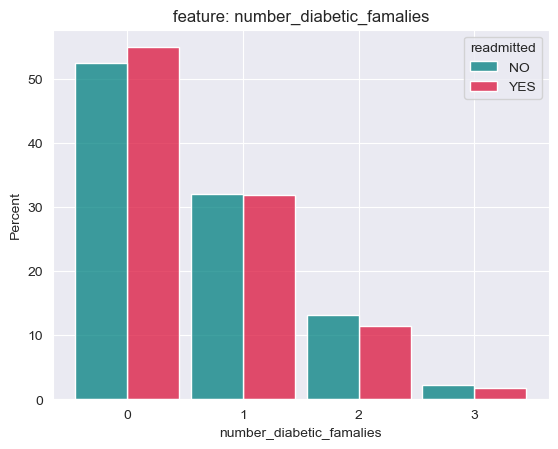

In [27]:
sns.histplot(data=drug_df.astype('category'), x='number_diabetic_famalies', **style).set_title('feature: number_diabetic_famalies')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [28]:
group_features = GroupFeatures(features=drugs_dict)

In [29]:
group_features.fit(df)
df = group_features.transform(df)


In [30]:
sum_features = SumFeatures(list(group_features.new_features), new_feature_name='number_diabetic_famalies')

In [31]:
sum_features.fit(df)

In [32]:
df = sum_features.transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

Text(0.5, 1.0, 'Number of diabetes drug families per patient vs readdmition')

([<matplotlib.axis.XTick at 0x184d69ddd80>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

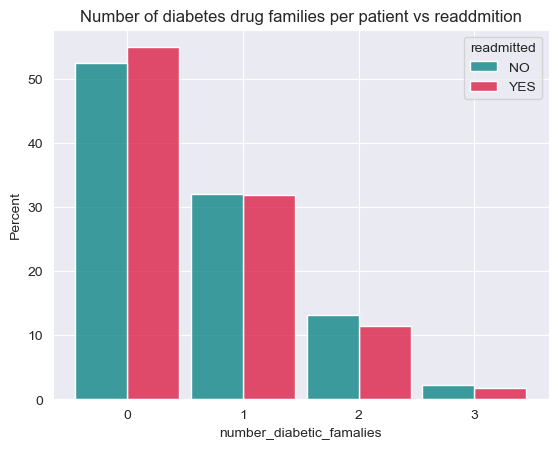

In [33]:

sns.histplot(data=drug_df, x='number_diabetic_famalies',shrink=.9, hue='readmitted', discrete=True, element='bars', multiple='dodge', common_norm=False, palette=["teal", "crimson"], stat='percent').set_title('Number of diabetes drug families per patient vs readdmition')
plt.xticks(range(len(drug_df['number_diabetic_famalies'].unique())), drug_df['number_diabetic_famalies'].unique())
# Show the plot
plt.show()


# from the two plots we see:
1. from the first plot, we can see that biguanides, sulfonylureas and reduce the number of readmissions. the other groups look not significant
2. from the second plot, it seems that using combination of drug families also reduse readmission.

we can further reduce the number of drug families to three by identifying common ground among the existing groups. 

1. **Biguanides and Related Combinations**: This group includes biguanides and medications that are commonly combined with them.
   - **Common Ground**: These drugs primarily work by reducing glucose production in the liver and improving insulin sensitivity in peripheral tissues.

2. **Sulfonylureas and Meglitinides**: This group includes sulfonylureas and meglitinides, which stimulate insulin release from pancreatic beta cells.
   - **Common Ground**: Both sulfonylureas and meglitinides act on pancreatic beta cells to enhance insulin secretion.

3. **Thiazolidinediones and Miscellaneous**: This group combines thiazolidinediones with other miscellaneous drugs.
   - **Common Ground**: Thiazolidinediones improve insulin sensitivity in peripheral tissues, while the miscellaneous drugs in this group may have various mechanisms of action.


This grouping aims to simplify the drug families while still capturing their common mechanisms of action or therapeutic properties.
let's do the same for the new grouping

it's looks like we can reduce the number of families to three and keep the same effect of 6 families.
1. we managed to improve the bias in our data by grouping the 22 features into 3 groups of drug families.
2. instead of deleting the bias features we group them to get more informative information.
   

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99343 entries, 0 to 99342
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   patient_nbr                           99343 non-null  int64 
 1   race                                  97109 non-null  object
 2   gender                                99343 non-null  object
 3   age                                   99343 non-null  object
 4   admission_type_id                     99343 non-null  int64 
 5   discharge_disposition_id              99343 non-null  int64 
 6   admission_source_id                   99343 non-null  int64 
 7   time_in_hospital                      99343 non-null  int64 
 8   medical_specialty                     50727 non-null  object
 9   num_lab_procedures                    99343 non-null  int64 
 10  num_procedures                        99343 non-null  int64 
 11  num_medications             

# 3. numeric features
Discover and Visualize the Data to Gain Insights

In [35]:
df.describe()

patient_nbr  admission_type_id  discharge_disposition_id  \
count  9.934300e+04       99343.000000              99343.000000   
mean   5.426117e+07           2.030259                  3.517882   
std    3.873426e+07           1.446373                  5.184359   
min    1.350000e+02           1.000000                  1.000000   
25%    2.338675e+07           1.000000                  1.000000   
50%    4.541774e+07           1.000000                  1.000000   
75%    8.756007e+07           3.000000                  3.000000   
max    1.895026e+08           8.000000                 28.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count         99343.000000      99343.000000        99343.000000   
mean              5.731083          4.379332           42.906929   
std               4.065029          2.968409           19.610032   
min               1.000000          1.000000            1.000000   
25%               1.000000          2.000000           31.000000   
50%               7.000000          4.000000           44.000000   
75%               7.000000          6.000000           57.000000   
max              25.000000         14.000000          132.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count    99343.000000     99343.000000       99343.000000      99343.000000   
mean         1.334236        15.979062           0.369246          0.198444   
std          1.702786         8.094909           1.265142          0.937734   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          1.000000        15.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          6.000000        81.000000          42.000000         76.000000   

       number_inpatient  number_diagnoses  biguanides_and_related  \
count      99343.000000      99343.000000            99343.000000   
mean           0.630935          7.401709                0.206809   
std            1.260428          1.941013                0.406508   
min            0.000000          1.000000                0.000000   
25%            0.000000          6.000000                0.000000   
50%            0.000000          8.000000                0.000000   
75%            1.000000          9.000000                0.000000   
max           21.000000         16.000000                2.000000   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
count                    99343.000000                          99343.000000   
mean                         0.306916                              0.140503   
std                          0.477158                              0.351427   
min                          0.000000                              0.000000   
25%                          0.000000                              0.000000   
50%                          0.000000                              0.000000   
75%                          1.000000                              0.000000   
max                          3.000000                              3.000000   

       number_diabetic_famalies  
count              99343.000000  
mean                   0.644877  
std                    0.786637  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%                    1.000000  
max                    3.000000

admission_type_id, discharge_disposition_id, and admission_source_id are IDs and thus need to be changed to categorical, We will deal with them later patient_nbr is indexed and not taken into account

Looking at the max and min values in the table above, we can see that there are outliers in number_outpatient, number_emergency, and number_inpatient. We will deal with them later.

In [36]:
# For now I will remove the diabetic drugs and the number of drug families 
numerical_columns = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses']

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'time_in_hospital')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_lab_procedures')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_procedures')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'num_medications')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_outpatient')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'number_emergency')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_inpatient')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, 'number_diagnoses')

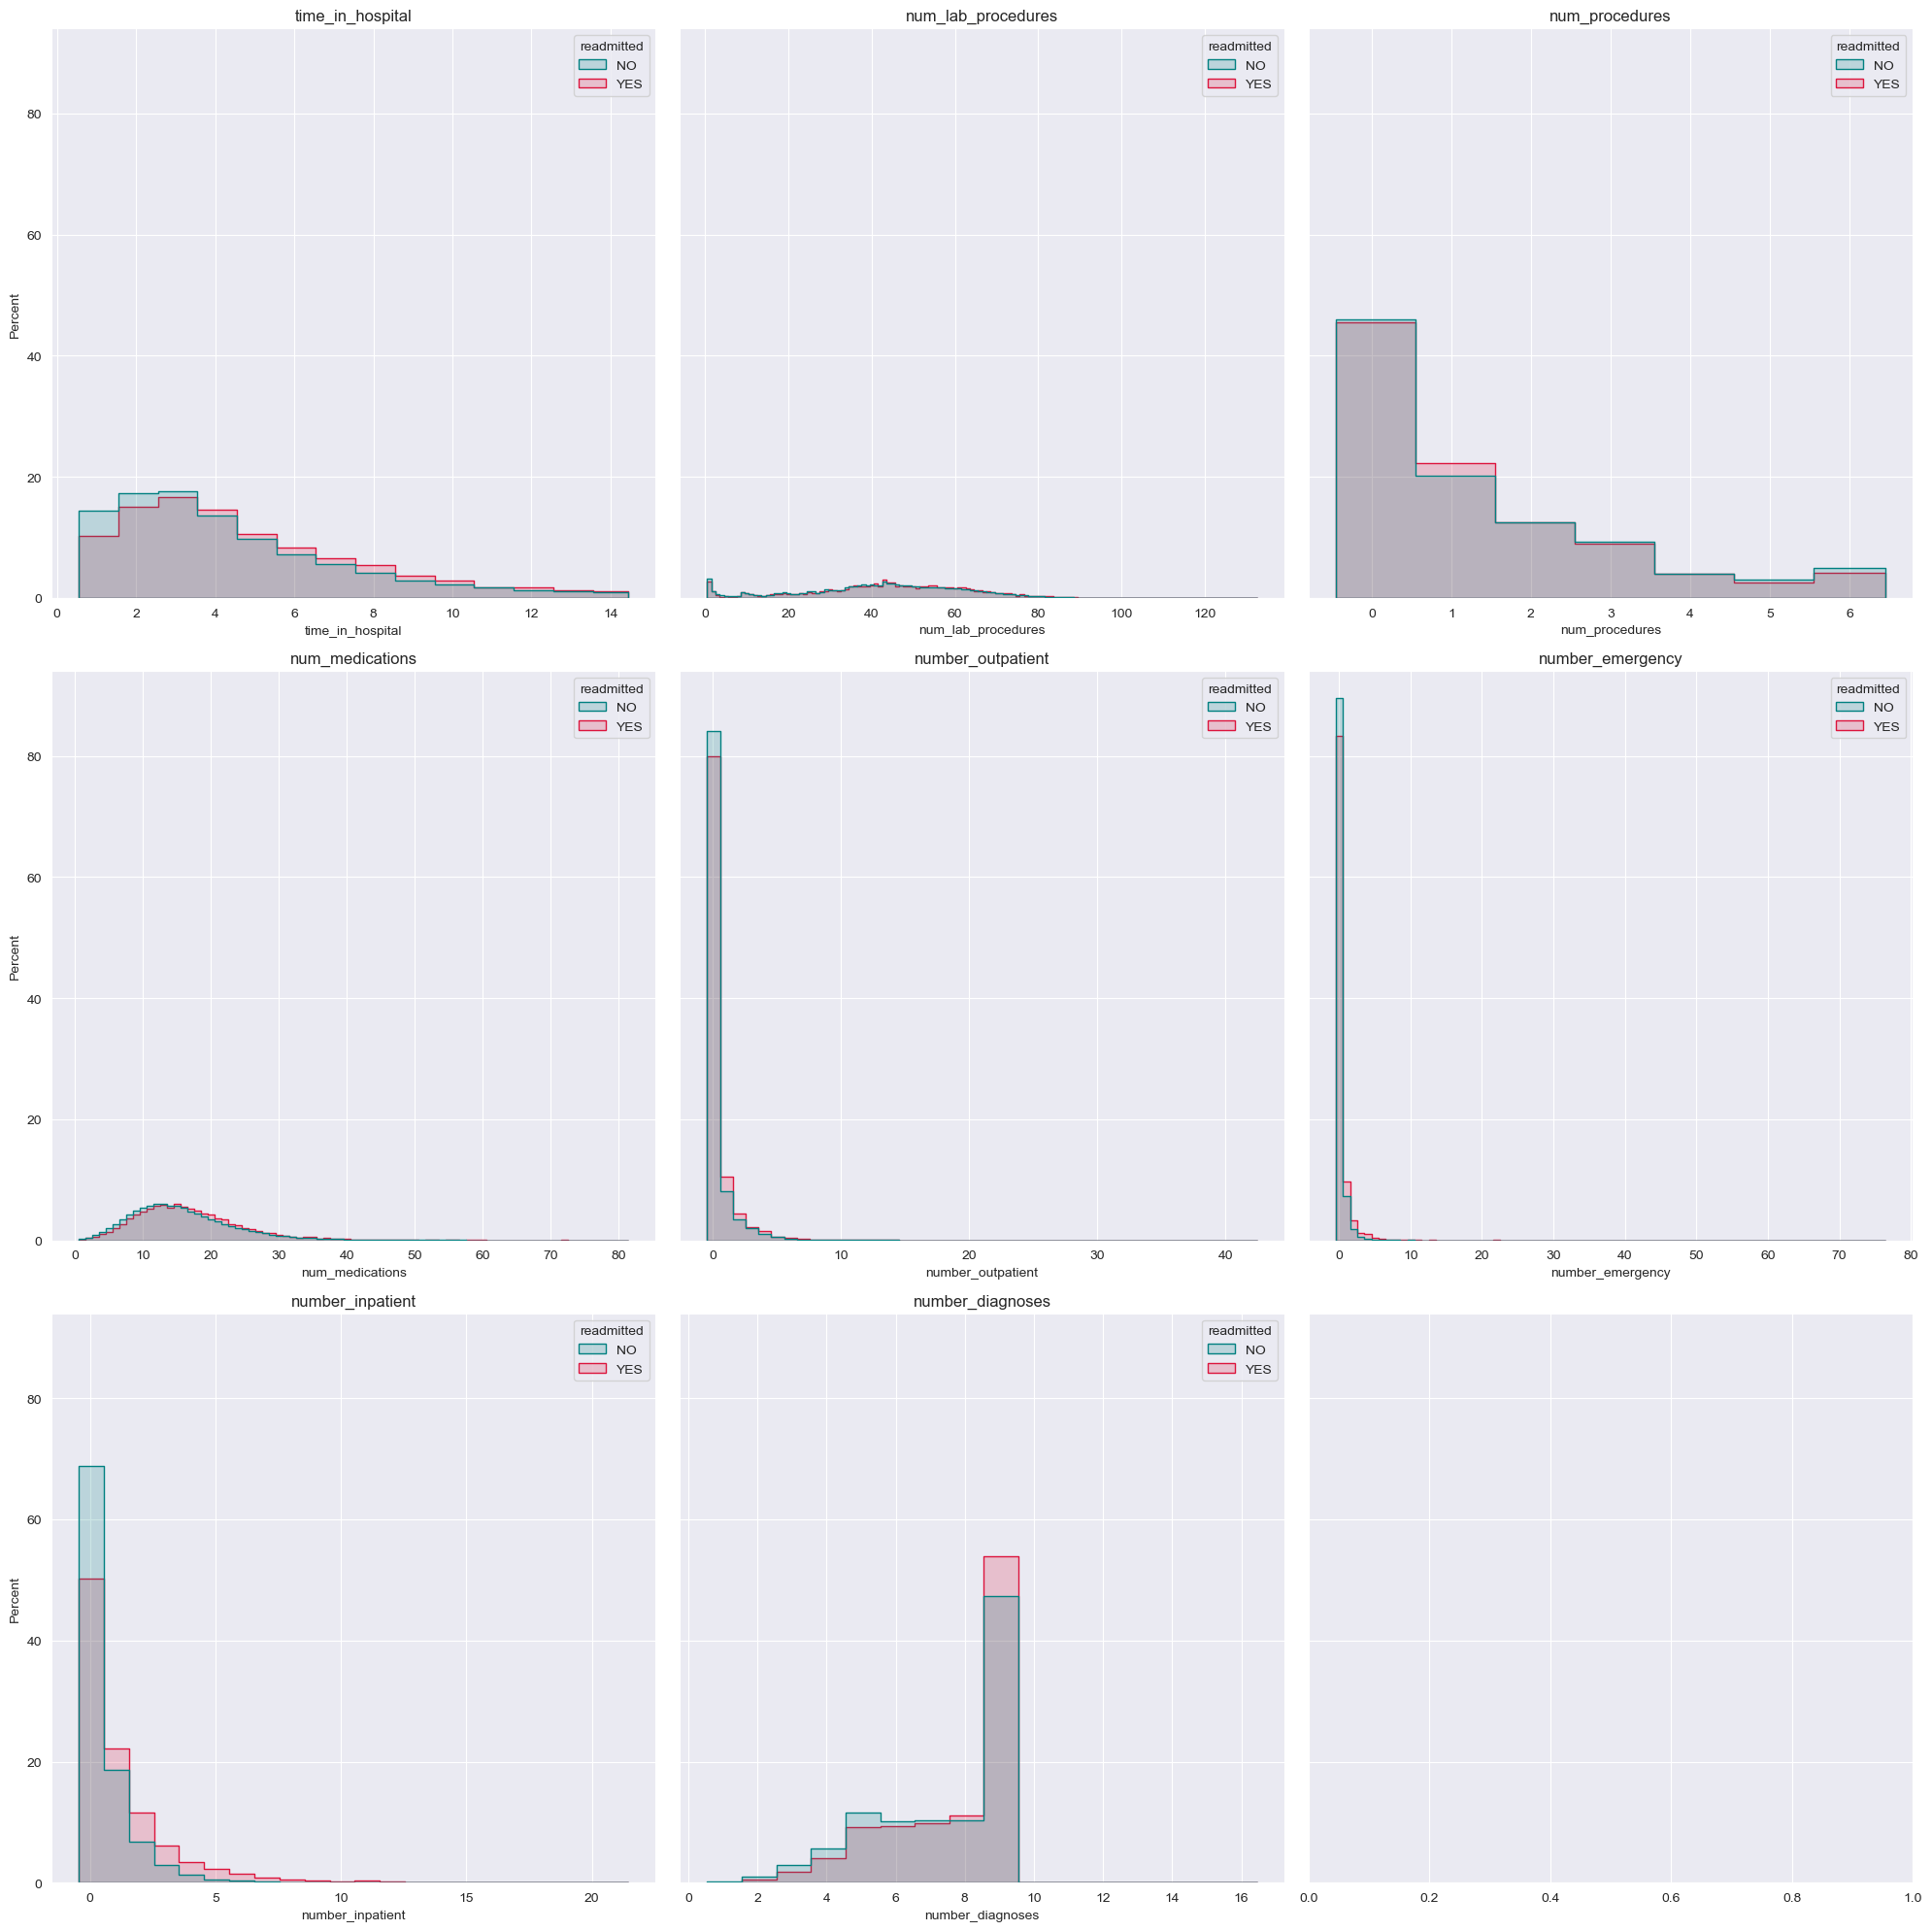

In [37]:
# let's look at the numerical data, we compare readmitted and not readmitted patients. we are looking at the percents so we can see if the distributions are different.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, column in enumerate(numerical_columns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=df, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

We see that "time_in_hospital",  "number_emergency", "number_inpatient", "number_outpatient", and "number_diagnoses" have a clear destribution diffrence.
we can also see thet 

before we remove any potential outliers we need to make sure that they are indeed nonvalid values that we can discard either based on domain knowledge or understanding of how the data was collected (e.g. due to some measurement errors).
Let's plot boxplots of the features with outliers and print the unique values in each one of them:

## 3.0 handle data skewness
Let's apply data transformation techniques:
1. logarithmic, 
2. square root
3. power transformations.

In [107]:
skewness_coloumns = [
                   'num_lab_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  ]

transformed_data = deepcopy(df[skewness_coloumns])


In [113]:
sqrt_data = np.sqrt(transformed_data)
sqrt_data['readmitted'] = df.readmitted

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_lab_procedures')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'num_medications')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_outpatient')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'number_emergency')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_inpatient')

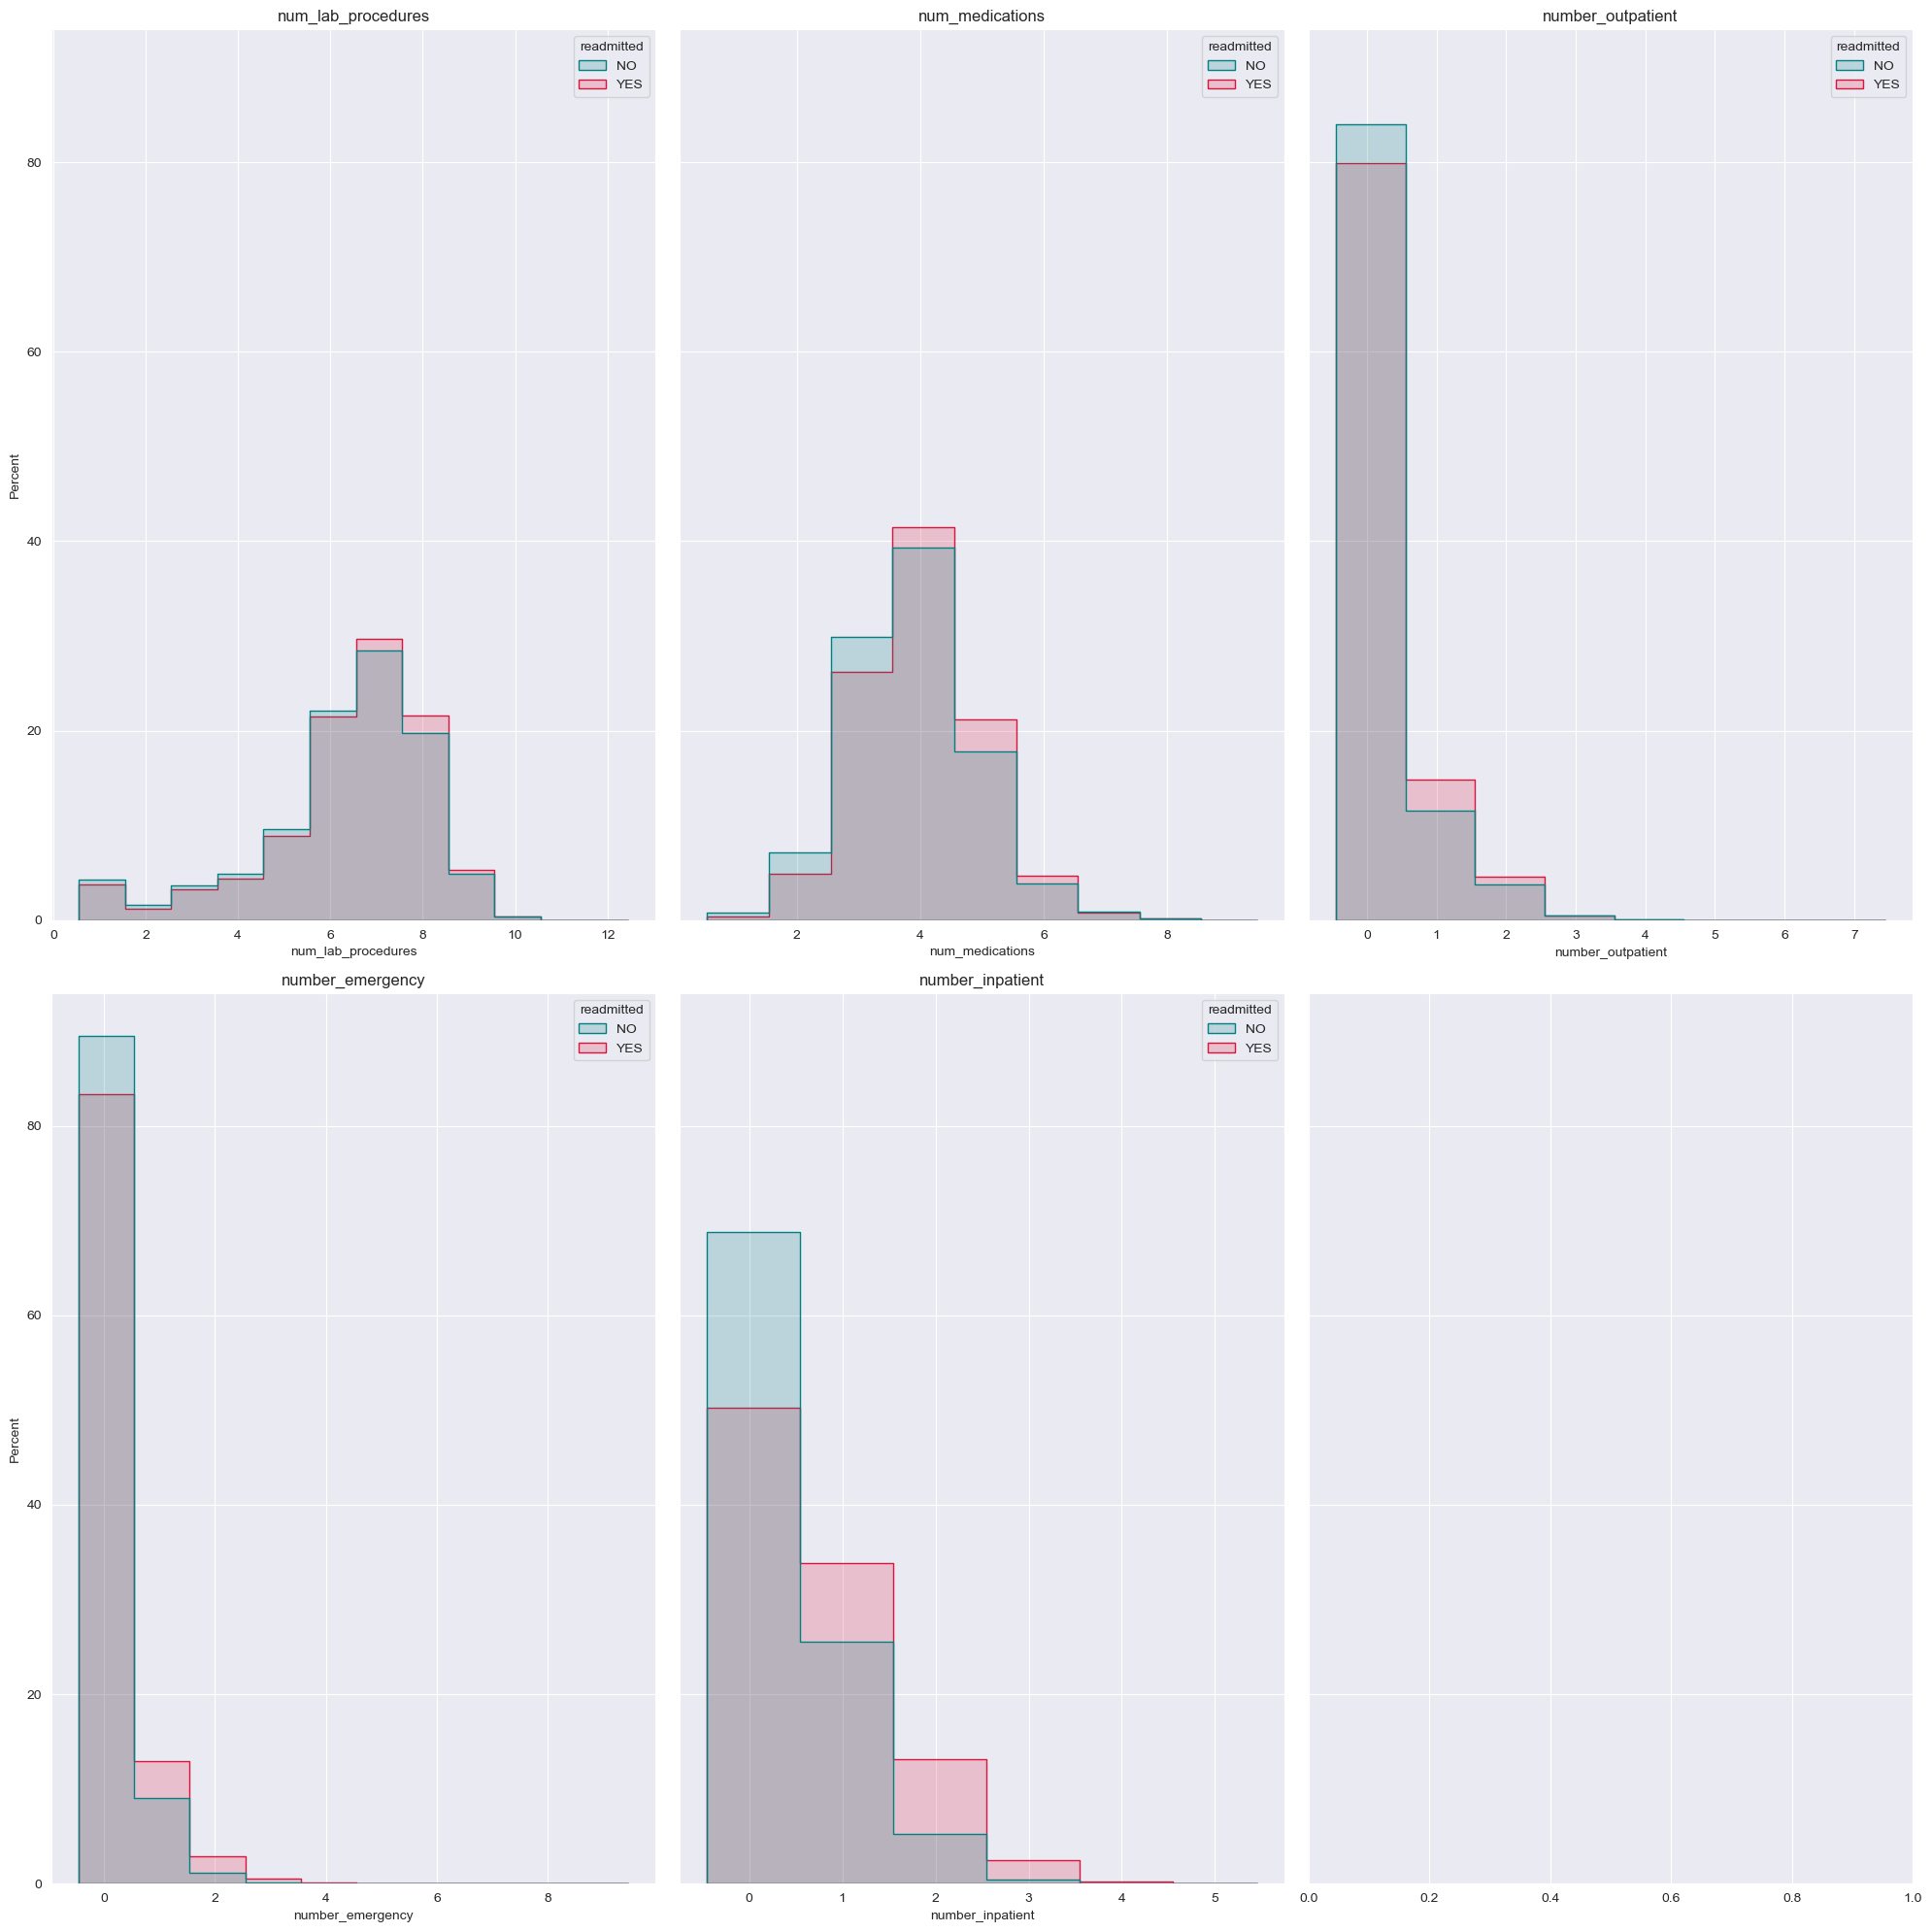

In [115]:
# let's look at the sqrt data, we compare readmitted and not readmitted patients. we are looking at the percents so we can see if the distributions are different.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, column in enumerate(skewness_coloumns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=sqrt_data, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [119]:
log_data = np.log(transformed_data)
log_data['readmitted'] = df.readmitted

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_lab_procedures')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'num_medications')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_outpatient')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'number_emergency')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_inpatient')

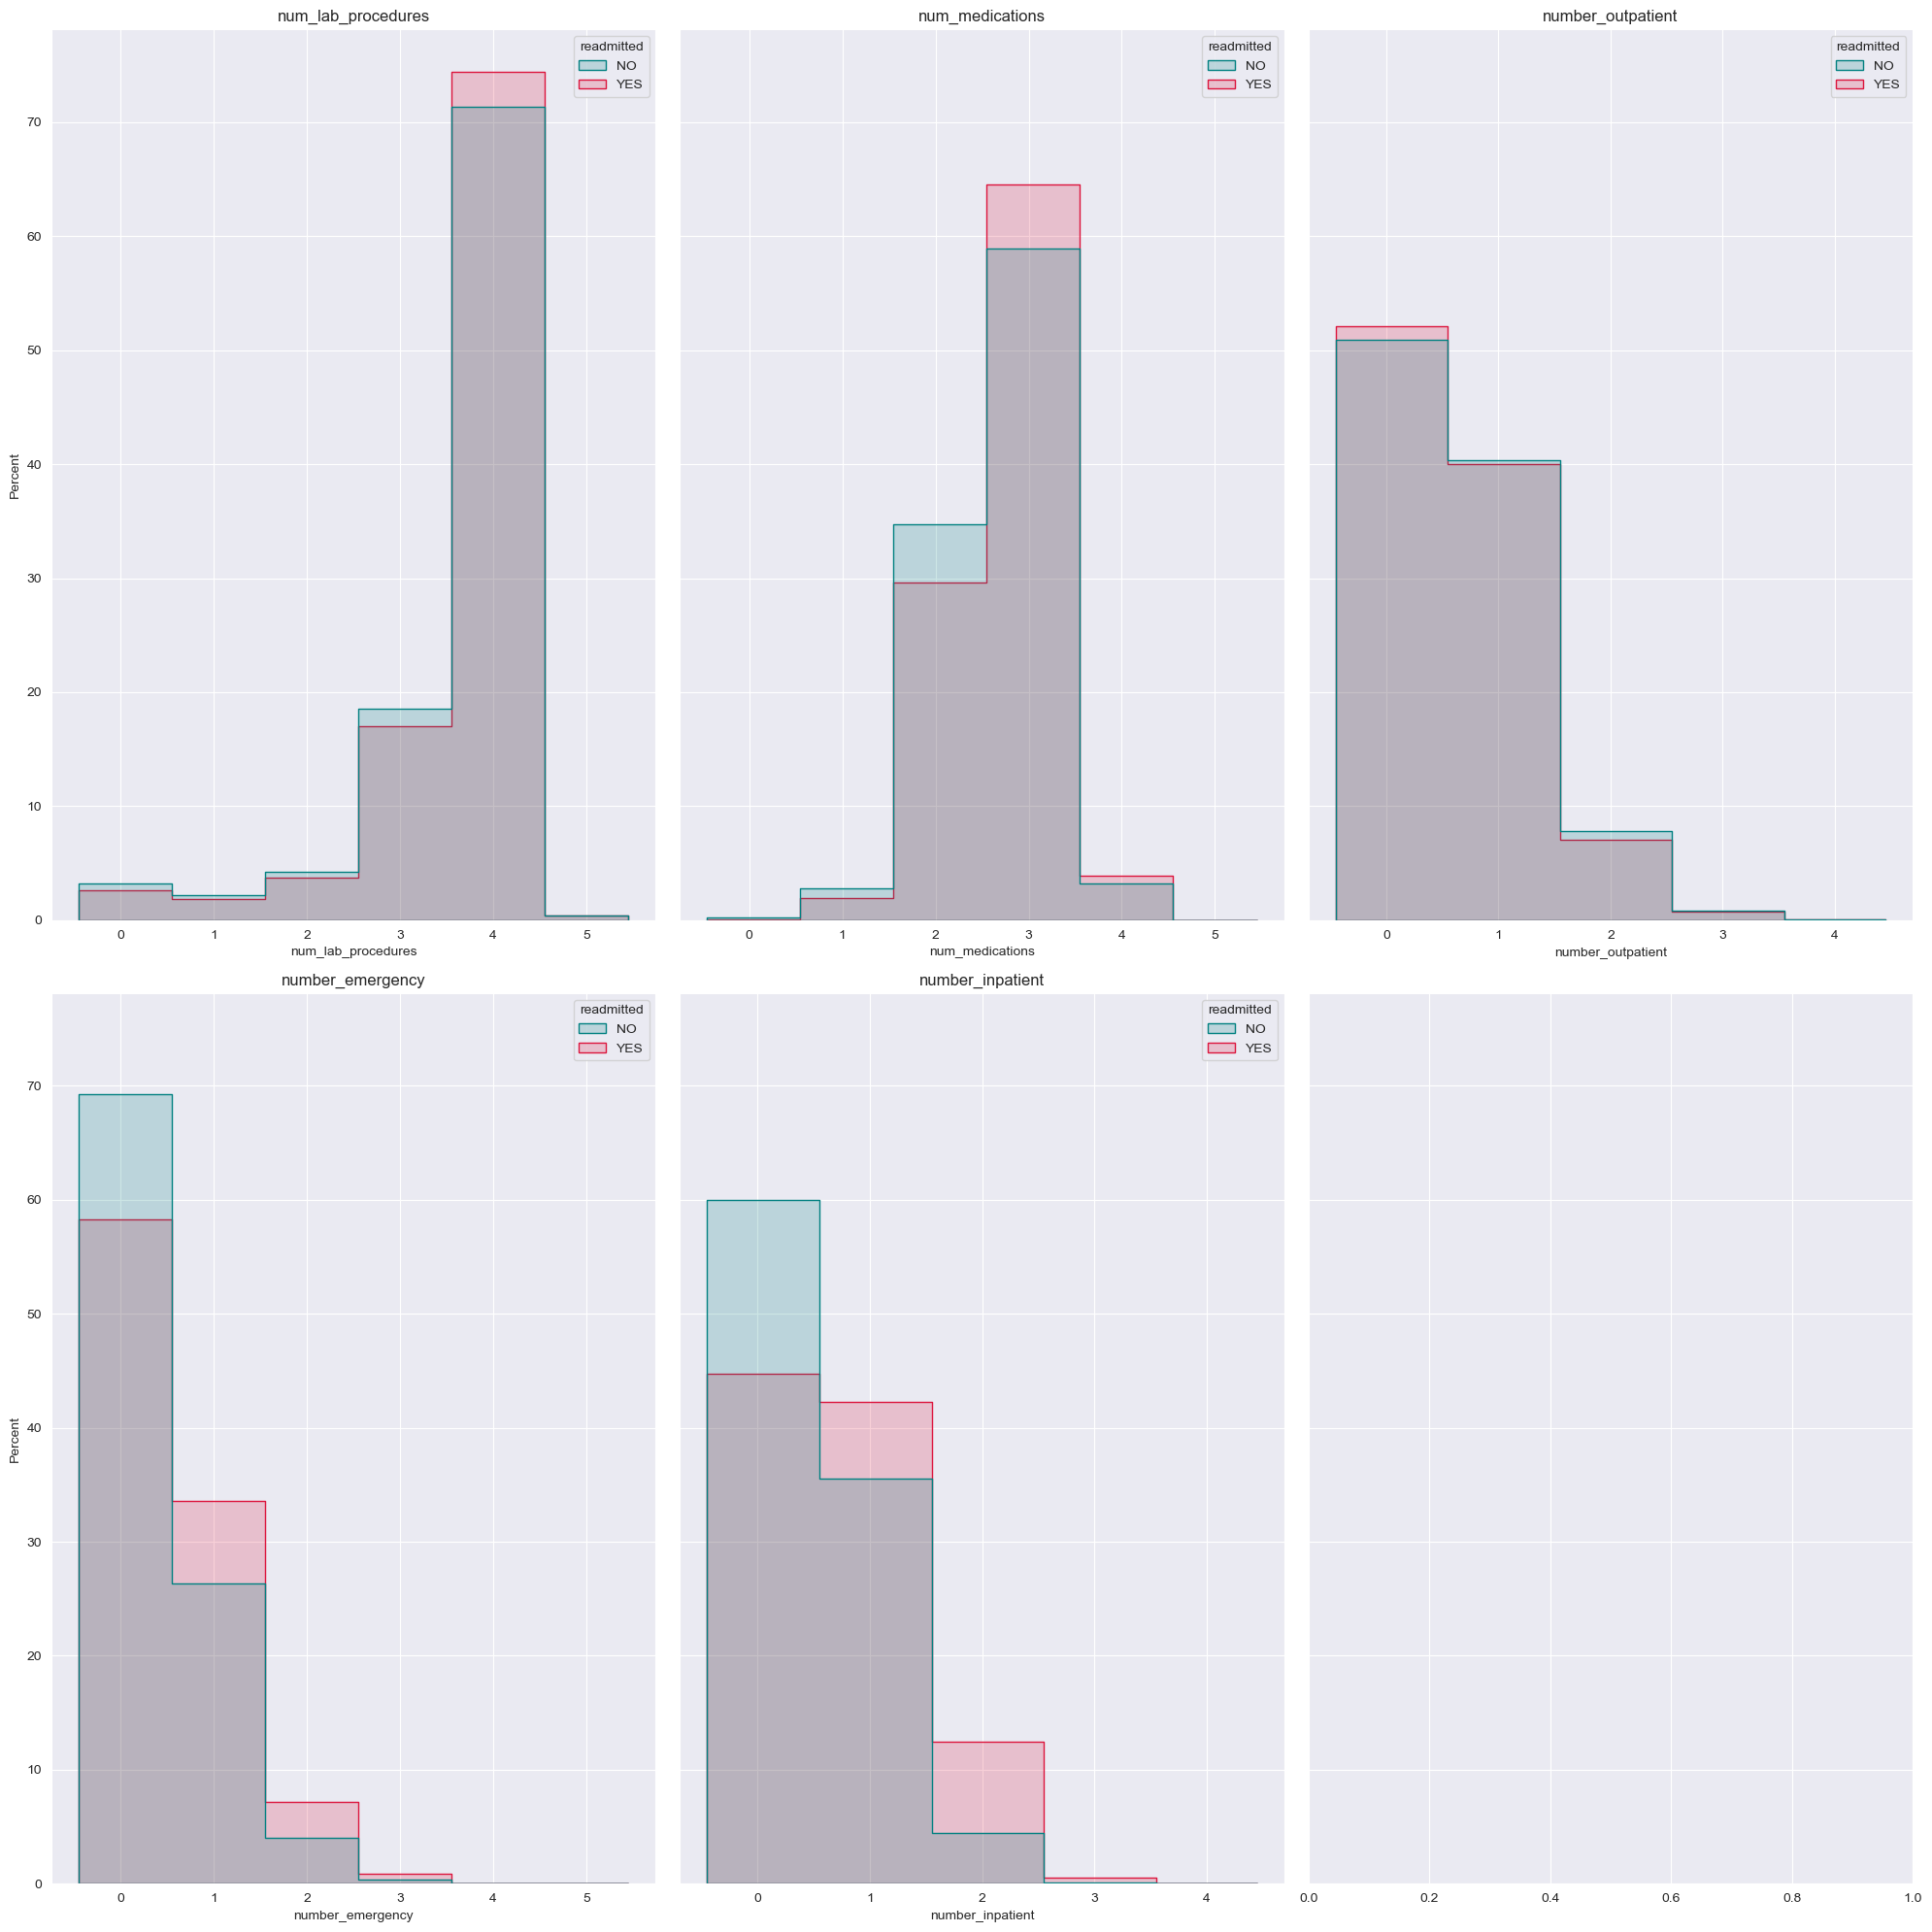

In [120]:
# let's look at the sqrt data, we compare readmitted and not readmitted patients. we are looking at the percents so we can see if the distributions are different.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, column in enumerate(skewness_coloumns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=log_data, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## 3.1 outliers

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='number_outpatient'>

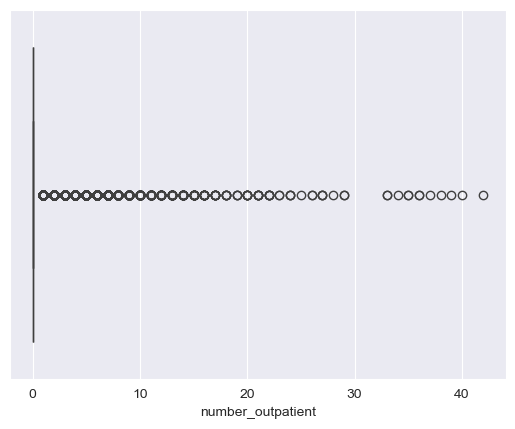

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='number_emergency'>

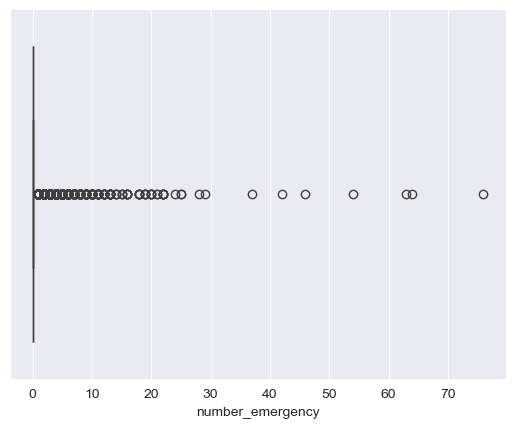

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='number_inpatient'>

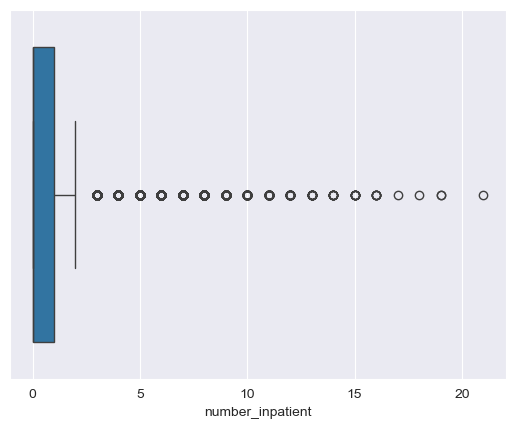

number_outpatient 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 33 34 35 36 37 38 39 40 42]
number_emergency 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 24 25
 28 29 37 42 46 54 63 64 76]
number_inpatient 6814 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21]


In [38]:
dict_outliers = {}

def boxplot_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    outliers_bool = (df[col] <= Q1 - 1.5 * IQR) | (df[col] >= Q3 + 1.5 *IQR)
    return df[col][outliers_bool]
col_to_check_for_outliers = ['number_outpatient', 'number_emergency', 'number_inpatient']

for col in col_to_check_for_outliers:
    dict_outliers.update({col : boxplot_outliers(col)})

# Creating individual plots
for var in col_to_check_for_outliers:
    sns.boxplot(x=var, data=df)
    plt.show()

for key, value in dict_outliers.items() :
    print (key, len(value), np.unique(value))

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: ylabel='Count'>

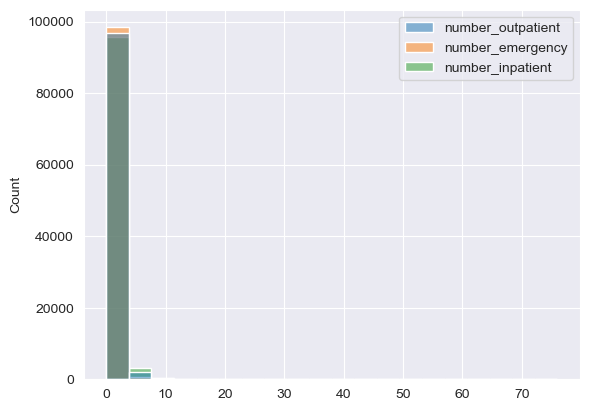

In [39]:
sns.histplot(df[col_to_check_for_outliers] )

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: ylabel='Count'>

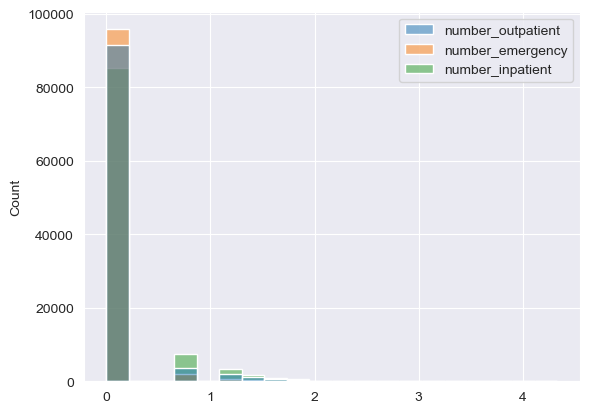

In [40]:
# one option is to change it to log
sns.histplot(np.clip(np.log(df[col_to_check_for_outliers]  + 0.0001), 0,10))

### we will deal with the outliers in the Cleaning Data section below


we are using cliping to solve the outliers

In [41]:
## 3.2 lets look at the diffrent distrebutions regarding the label

In [42]:
# To see the diffrence between the two groups we ploted both an histogram of the numerical values and the papulation destribution, the distribution allows us to compere the unbalanced data

# out of this plots we see can't see a big difrence in: 'num_lab_procedures', 'num_procedures', 'number_outpatient' and 'number_emergency'.
# and we can see some difrence in: 'time_in_hospital' (higher values in longer time for readmitted), 'num_medications' (more medications for readmitted), 'number_inpatient' (pepole that readmit tend to go more to hospitals)
# and finaly number_diagnose (readmitted pations have more diagnoses)

## 3.3 Looking for Correlations

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Plot of df')

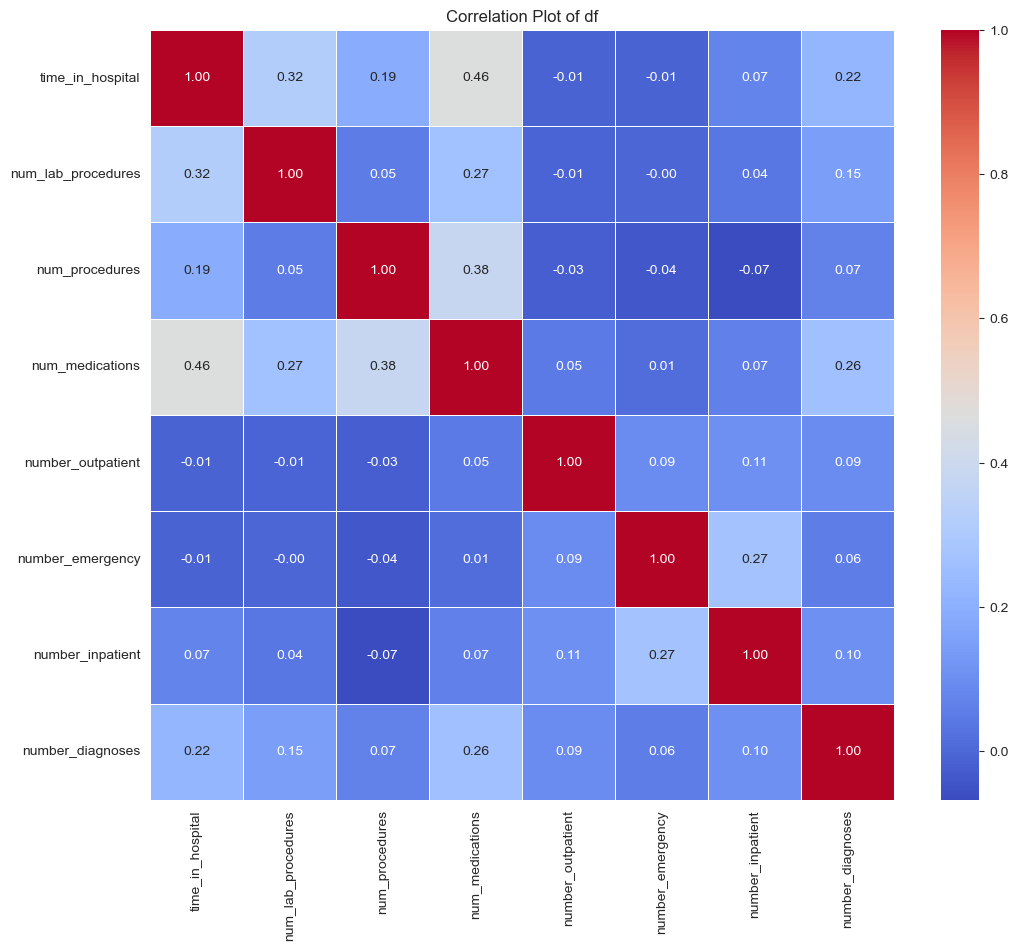

In [43]:
correlation_matrix = df[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Plot of df")
plt.show()

array([[<Axes: xlabel='time_in_hospital', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_lab_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_medications', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_outpatient', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_emergency', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_inpatient', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_diagnoses', ylabel='time_in_hospital'>],
       [<Axes: xlabel='time_in_hospital', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_lab_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_medications', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_outpatient', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_emergency', ylabel='num_lab_procedures'>,
       

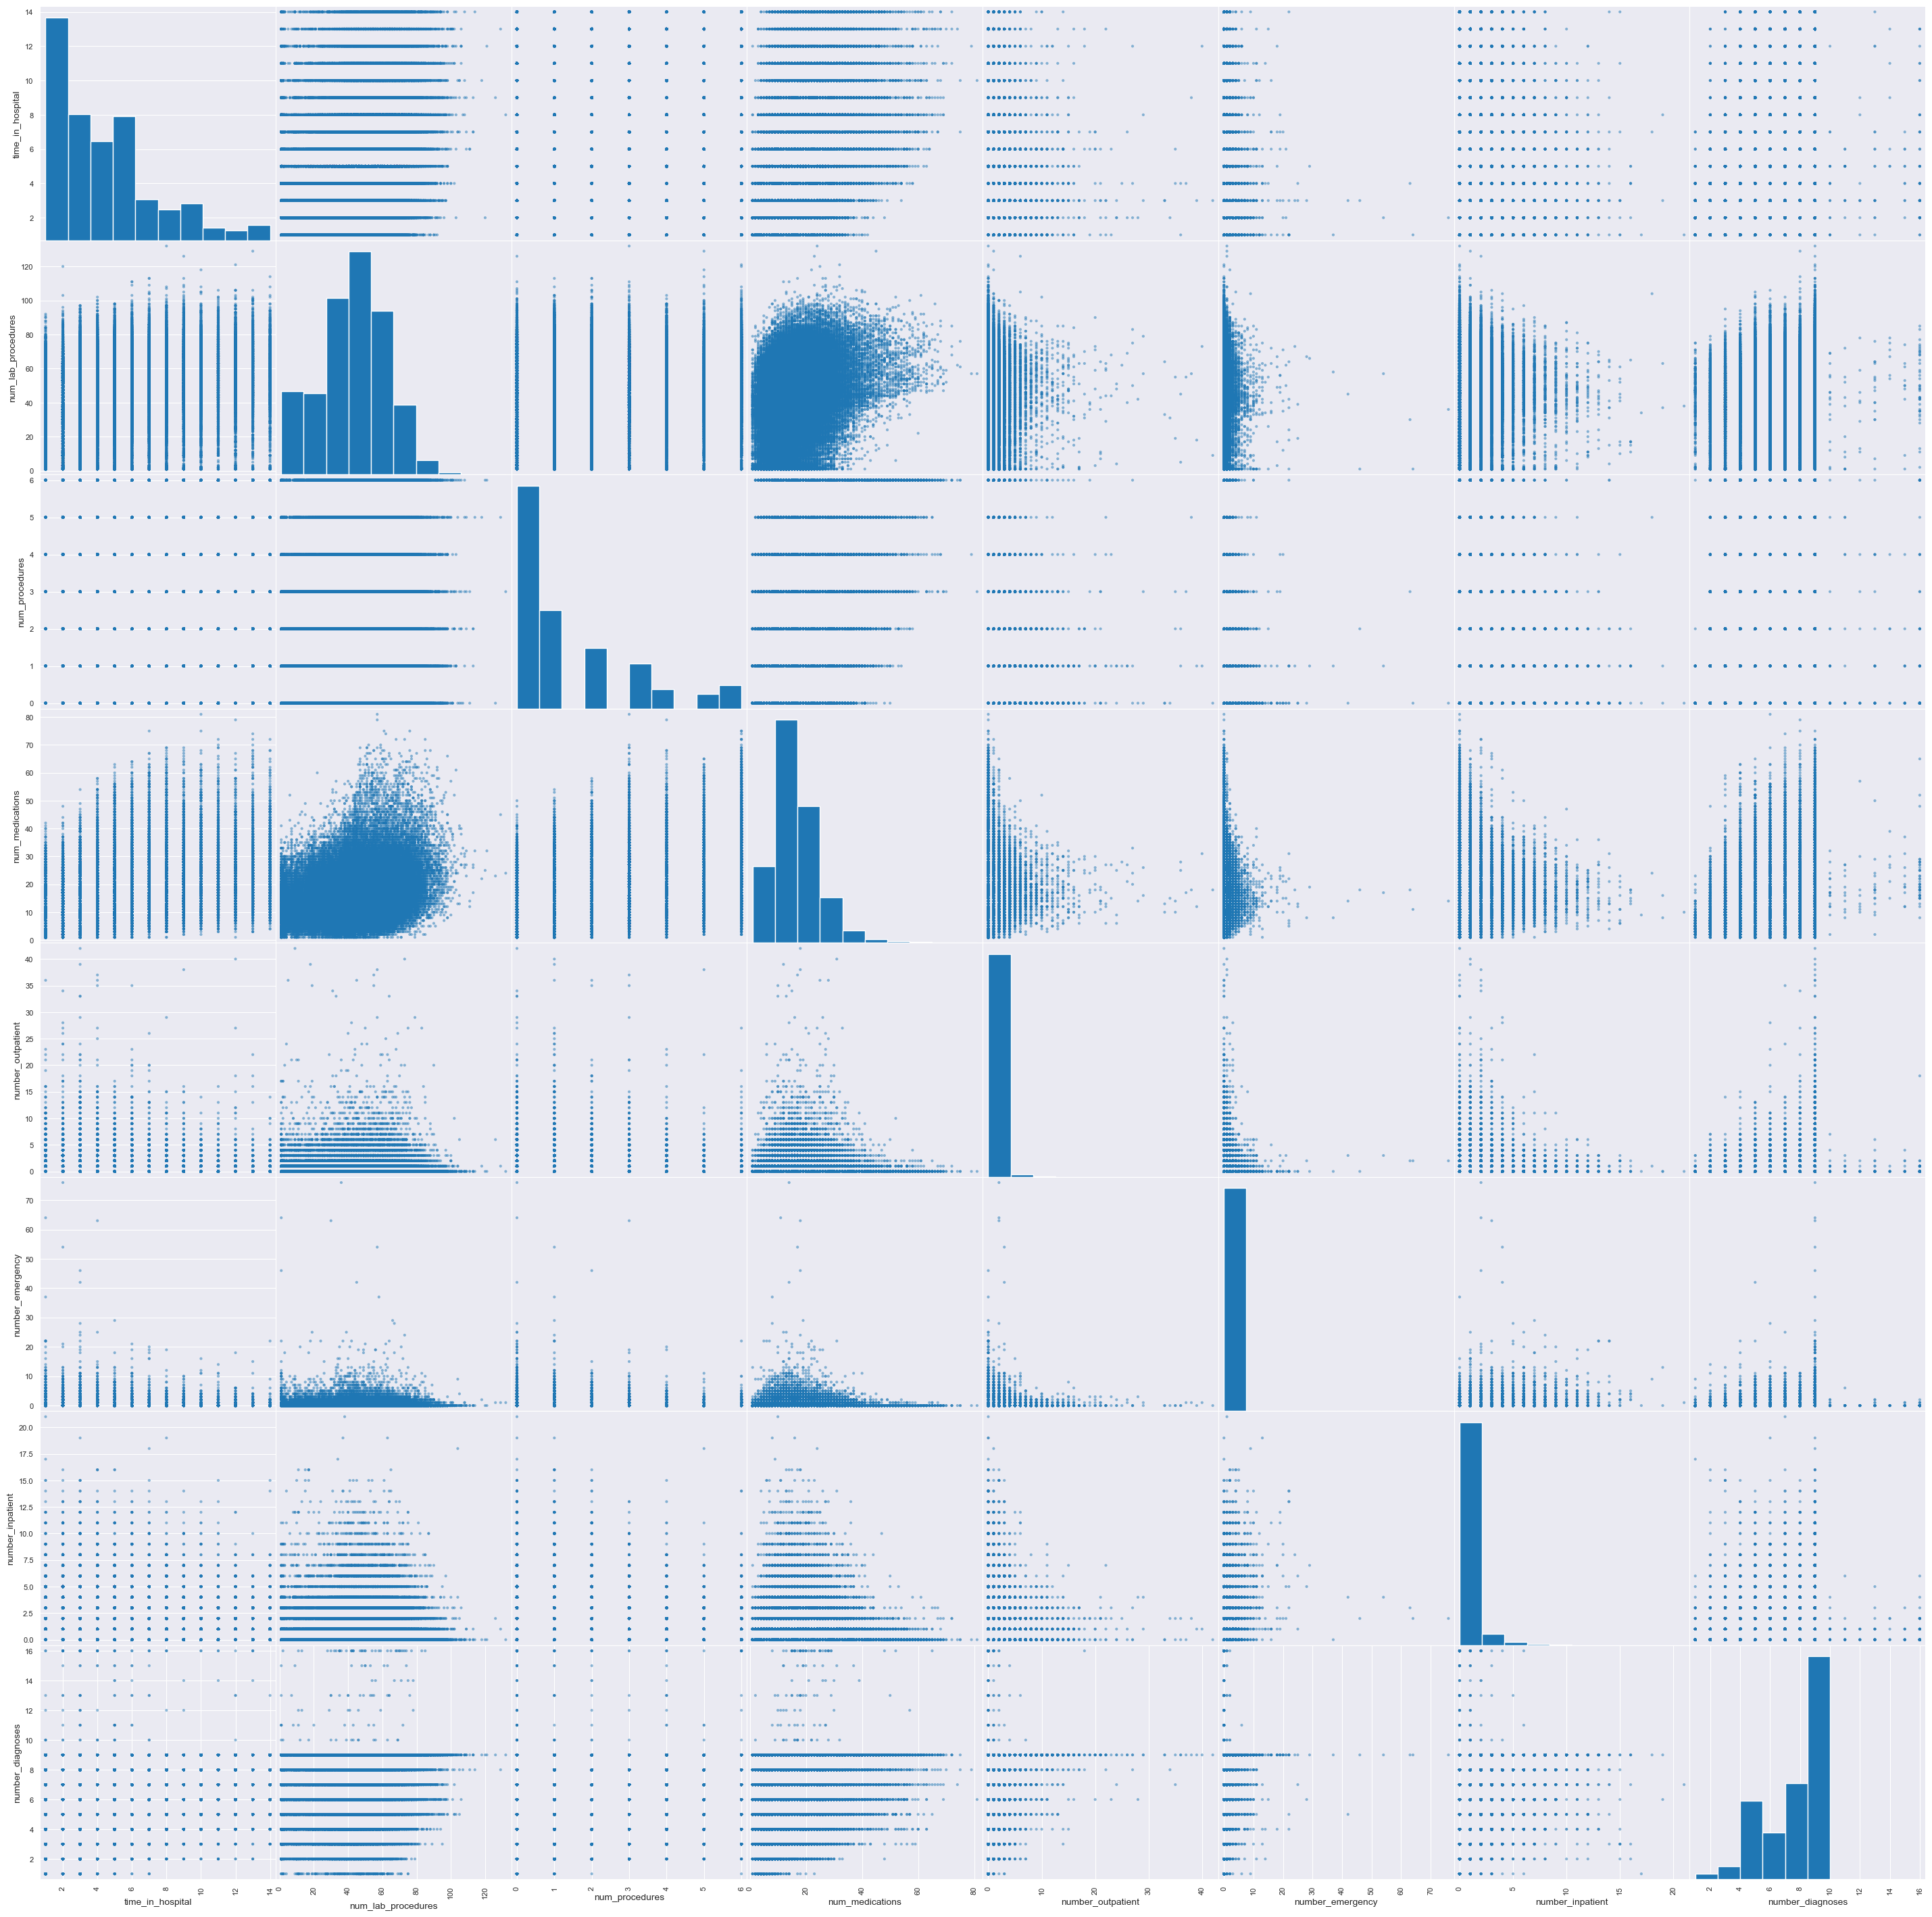

In [44]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numerical_columns], figsize=(36, 36))


In [45]:

# we can see some correlation between time in the hospital and procedures and number of medications
# to get beter resulotion of the diffrences we need to remove the outliers 

# We need to use RubustScalar to scale this columns!

# 4 Categorical columns
lets look on the categorical columns in our data
1. we want to look on the namber of catagories there are in each category
2. we want to remove categories with a single value or a value that is higher then 95 percent of the data
3. we want to reduse the dimentionalty of the categories

In [46]:
# lets look on all the categirical coloumns and see how many unique values they have and what is the percent
df_categorical = df.drop(columns=numerical_columns+['biguanides_and_related', 'sulfonylureas_and_meglitinides', 'thiazolidinediones_and_miscellaneous', 'number_diabetic_famalies'])
df_categorical.drop(columns=['patient_nbr'], inplace=True)


In [47]:
df_categorical

race  gender      age  admission_type_id  \
0            Caucasian  Female   [0-10)                  6   
1            Caucasian  Female  [10-20)                  1   
2      AfricanAmerican  Female  [20-30)                  1   
3            Caucasian    Male  [30-40)                  1   
4            Caucasian    Male  [40-50)                  1   
...                ...     ...      ...                ...   
99338  AfricanAmerican    Male  [70-80)                  1   
99339  AfricanAmerican  Female  [80-90)                  1   
99340        Caucasian    Male  [70-80)                  1   
99341        Caucasian  Female  [80-90)                  2   
99342        Caucasian    Male  [70-80)                  1   

       discharge_disposition_id  admission_source_id  \
0                            25                    1   
1                             1                    7   
2                             1                    7   
3                             1                    7   
4                             1                    7   
...                         ...                  ...   
99338                         3                    7   
99339                         4                    5   
99340                         1                    7   
99341                         3                    7   
99342                         1                    7   

              medical_specialty  diag_1  diag_2 diag_3 max_glu_serum  \
0      Pediatrics-Endocrinology  250.83     NaN    NaN           NaN   
1                           NaN     276  250.01    255           NaN   
2                           NaN     648     250    V27           NaN   
3                           NaN       8  250.43    403           NaN   
4                           NaN     197     157    250           NaN   
...                         ...     ...     ...    ...           ...   
99338                       NaN  250.13     291    458           NaN   
99339                       NaN     560     276    787           NaN   
99340                       NaN      38     590    296           NaN   
99341           Surgery-General     996     285    998           NaN   
99342                       NaN     530     530    787           NaN   

      A1Cresult insulin change diabetesMed readmitted  
0           NaN      No     No          No         NO  
1           NaN      Up     Ch         Yes         NO  
2           NaN      No     No         Yes         NO  
3           NaN      Up     Ch         Yes         NO  
4           NaN  Steady     Ch         Yes         NO  
...         ...     ...    ...         ...        ...  
99338        >8    Down     Ch         Yes         NO  
99339       NaN  Steady     No         Yes         NO  
99340       NaN    Down     Ch         Yes         NO  
99341       NaN      Up     Ch         Yes         NO  
99342       NaN      No     No          No         NO  

[99343 rows x 16 columns]

In [48]:
categorical_columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

## 4.2 veiw featurs uniqe value
we are doimg this to fimd places where we could reduse dimentionalty

<Figure size 800x4000 with 0 Axes>

0it [00:00, ?it/s]

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dek

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
14it [00:23,

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
15it [00:23,

<Axes: >

C:\Users\dekel\AppData\Local\Temp\ipykernel_16072\3571526672.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
16it [00:23,

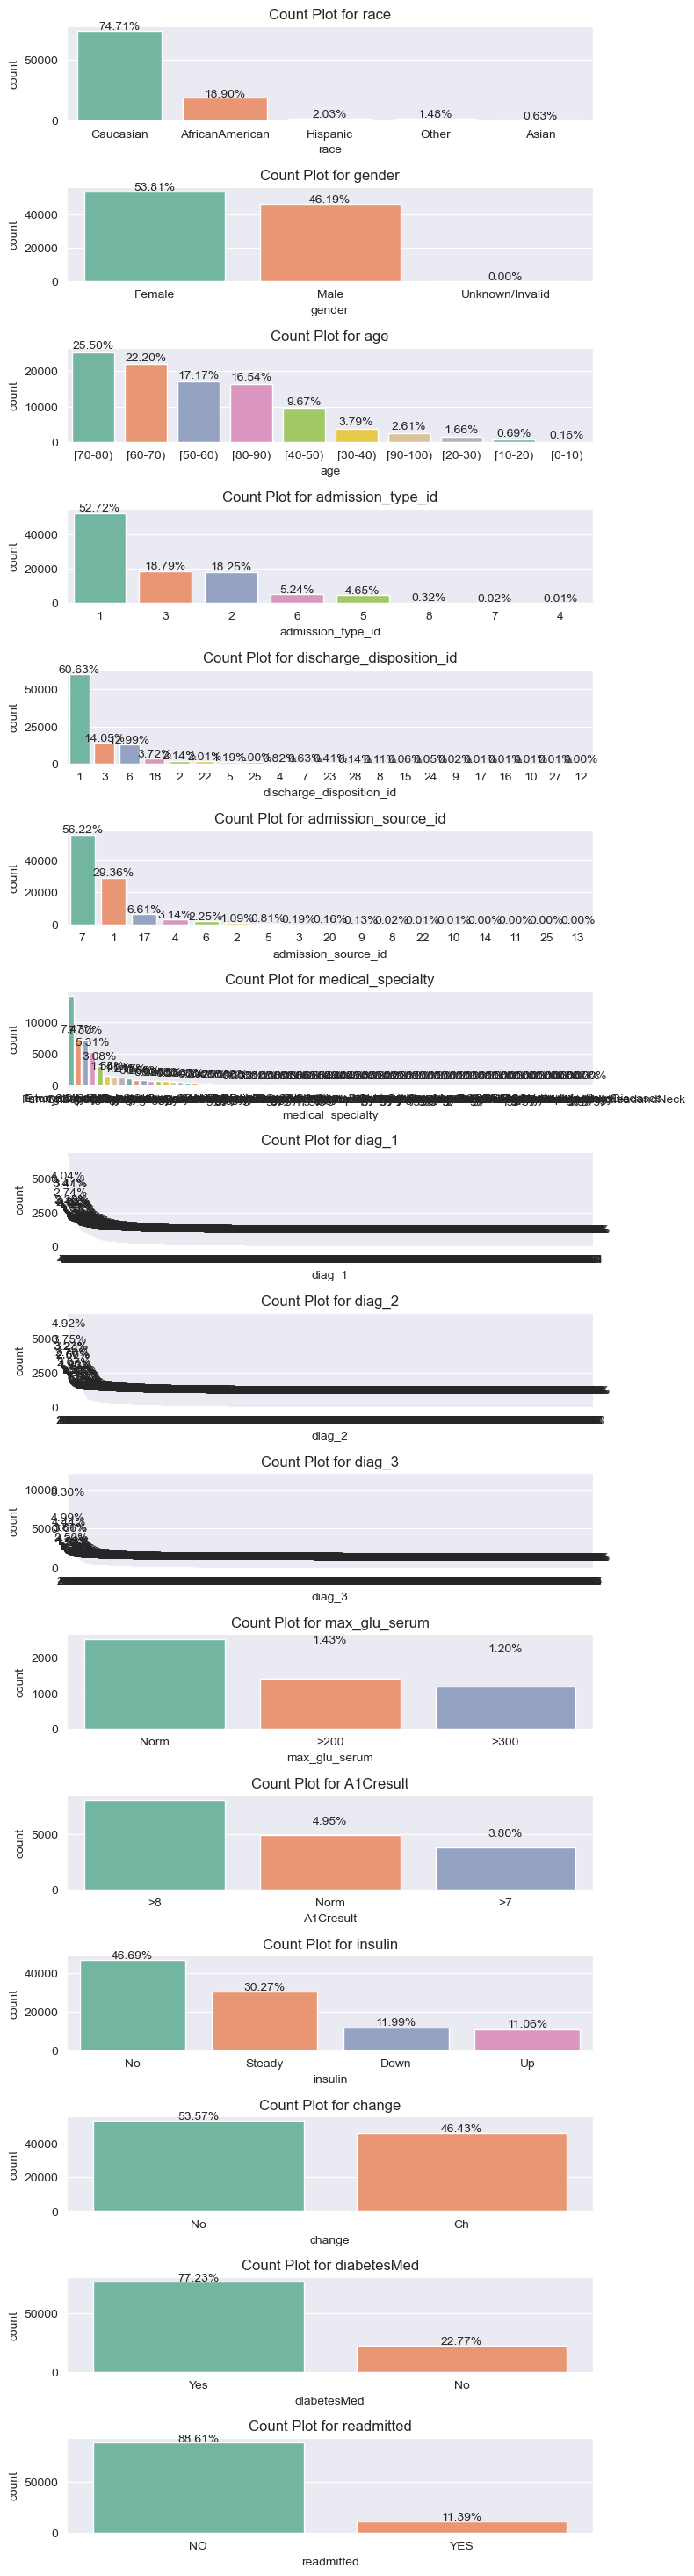

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# We would like to see how many categories we have and what the distribution is. We will modify the different categories to reduce dimensionality where possible
plt.figure(figsize=(8, 40))  
# Create a subplot with 22 rows and 1 column
plt.subplots_adjust(hspace=0.5)  
# Loop through each column and create count plots
for i, column in tqdm(enumerate(df_categorical.columns, 1)):  # Start counting from 1 for subplot index
    plt.subplot(22, 1, i)
    ax = plot_categorical_with_percent(df_categorical, column, palette="Set2")

# Adjust layout
plt.tight_layout()
plt.show()


## 4.3 inspect gender

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='gender', ylabel='Percent'>

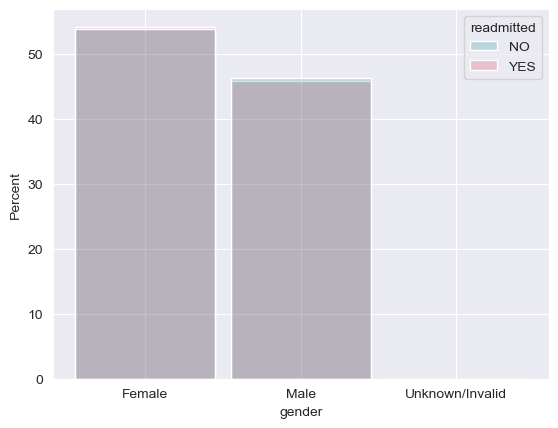

In [50]:
# lets look at gender dest:
# plot_categorical_with_percent(df_categorical, )
x='gender'
desired_order = df_categorical[x].value_counts().index.tolist()  # Get the desired order of bars
# Sort the DataFrame based on the desired order
data = df_categorical[df_categorical[x].isin(desired_order)]
sns.histplot(x=x, data=data ,shrink=.9, hue='readmitted', discrete=True, element='bars', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

In [51]:
# we will remove rwos with inknown gender
gender_remover = dt.RowRemoverByFeatureValue('gender', exclude_vals=['Unknown/Invalid'])
df = gender_remover.fit_transform(df)



C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='gender', ylabel='Percent'>

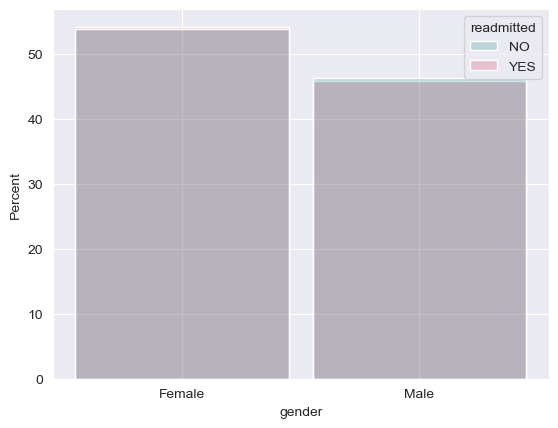

In [52]:
sns.histplot( x='gender', data=df,shrink=.9, hue='readmitted', discrete=True, element='bars', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

## 4.4 inspect discharge_disposition

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

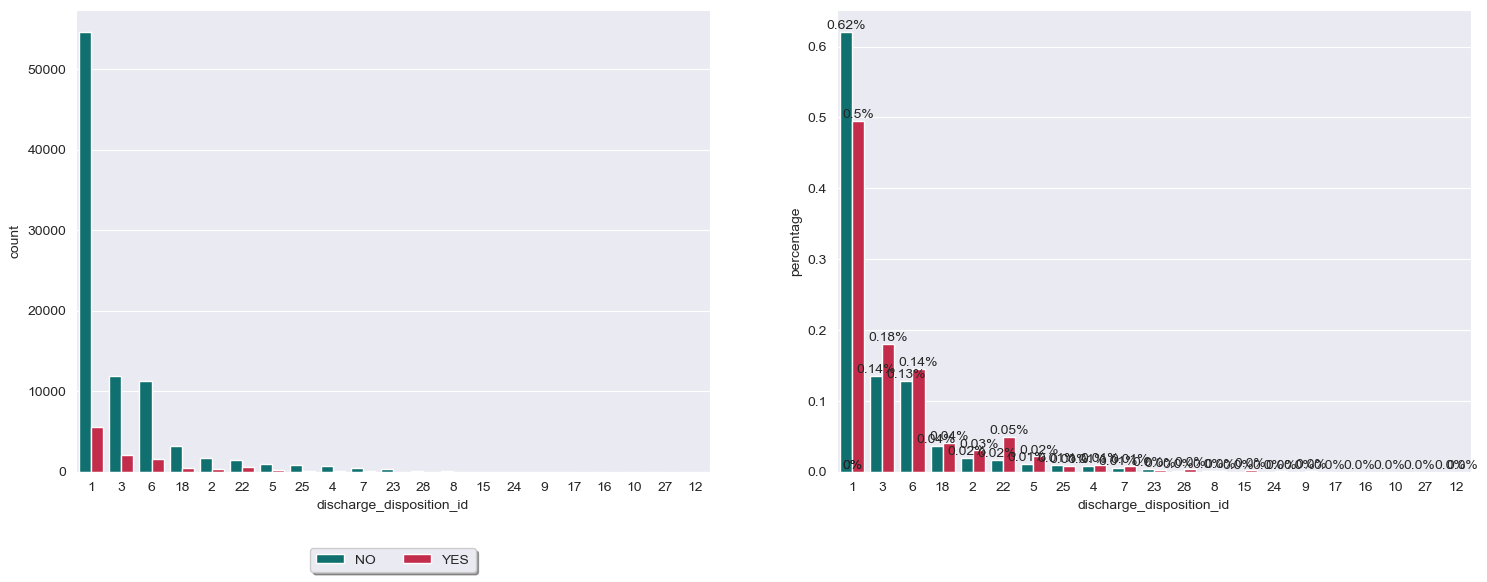

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_dual_plot(x, data, hue, palette,  figsize=(12, 6)):
    # Calculate the order of bars by counts
    order = data[x].value_counts().index

    # Create subplots
    f, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot countplot on the first subplot
    sns.countplot(x=x, data=data, hue=hue, order=order, palette=palette, ax=axes[0])

    # Plot percentplot on the second subplot
    prop_df = (data[x]
               .groupby(data[hue])
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

    g = sns.barplot(x=x, y='percentage', hue=hue, data=prop_df, ax=axes[1], palette=palette, order=order)

    # Place legend beneath both plots
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=len(pd.unique(data[x])))
    axes[1].get_legend().remove()  # Remove legend from the second plot

    # Add percentage labels to the bars in the countplot
    for p in g.patches:
        txt = str(np.round(p.get_height(), decimals=2)) + '%'
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = p.get_height()
        g.annotate(txt, (txt_x, txt_y), ha='center', va='bottom')

    # Show the plots
    plt.show()


x = 'discharge_disposition_id'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(18, 6))


In [54]:
change_duscharde_to_home_or_not = dt.CategoryReducer(feature='discharge_disposition_id', lookup={'home': [1]})
change_duscharde_to_home_or_not.prop_setter = prop_setter
change_duscharde_to_home_or_not._fit(df)
df = change_duscharde_to_home_or_not.transform(df)

CategoryReducer(feature='discharge_disposition_id', lookup={'home': [1]})

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

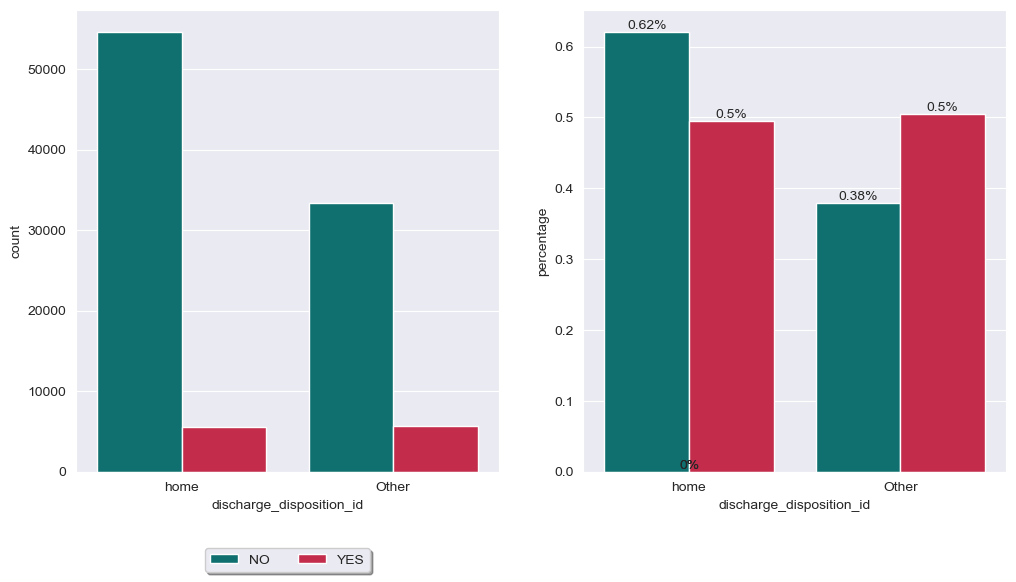

In [55]:
x = 'discharge_disposition_id'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.5 inspect admission_type_id
change the admission to categorical, reduce to other, high_prayority, clinic_referral
admission_type_id	description
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
we are grouping togeter: 8,6,5 toggeter as 'other', 1,2 as high_prayority and else as clinic referral




C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

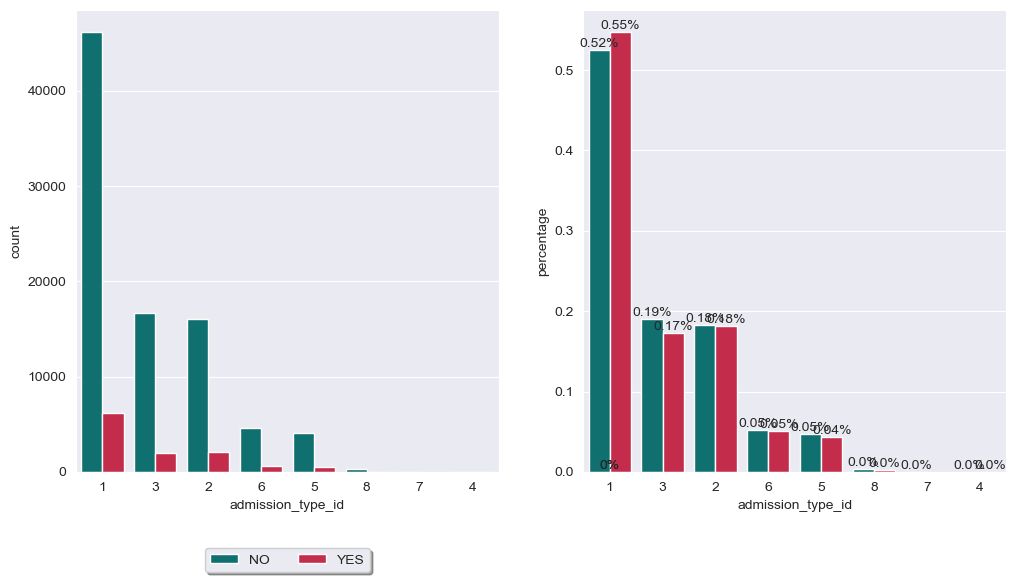

In [56]:
x = 'admission_type_id'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

In [57]:
admission_reduse = dt.CategoryReducer(feature='admission_type_id', lookup={'HighPriority': [1, 2], 'ClinicReferral': [3, 4, 7]})
admission_reduse.prop_setter = prop_setter
admission_reduse._fit(df)
df = admission_reduse.transform(df)



CategoryReducer(feature='admission_type_id',
                lookup={'ClinicReferral': [3, 4, 7], 'HighPriority': [1, 2]})

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

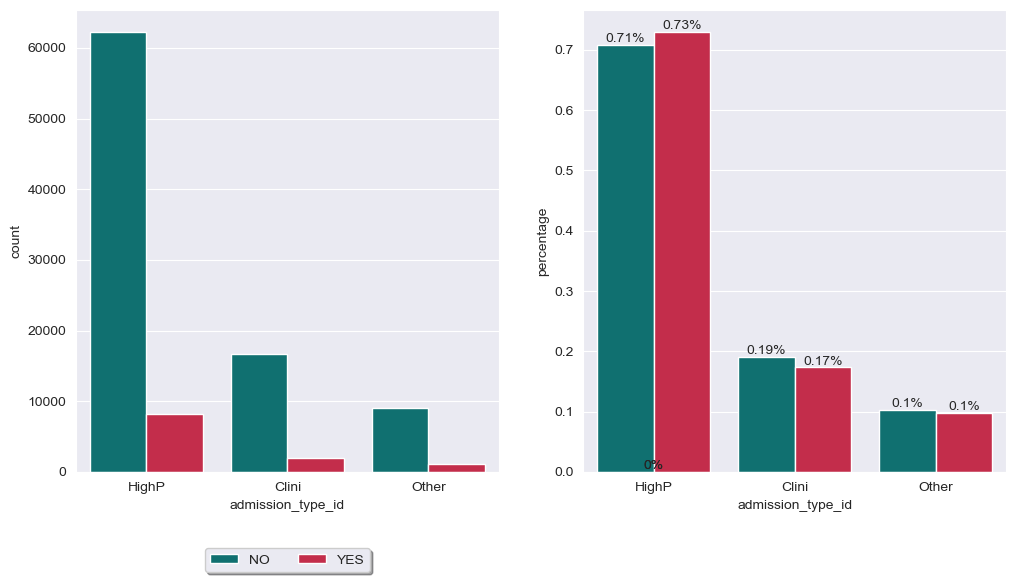

In [58]:
x = 'admission_type_id'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.6 inspect race
We see that caucasian and African American are ~92 % of the data so we will unite oTHER, ASIAN AND HISPANIC to reduce dimentionalty


C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

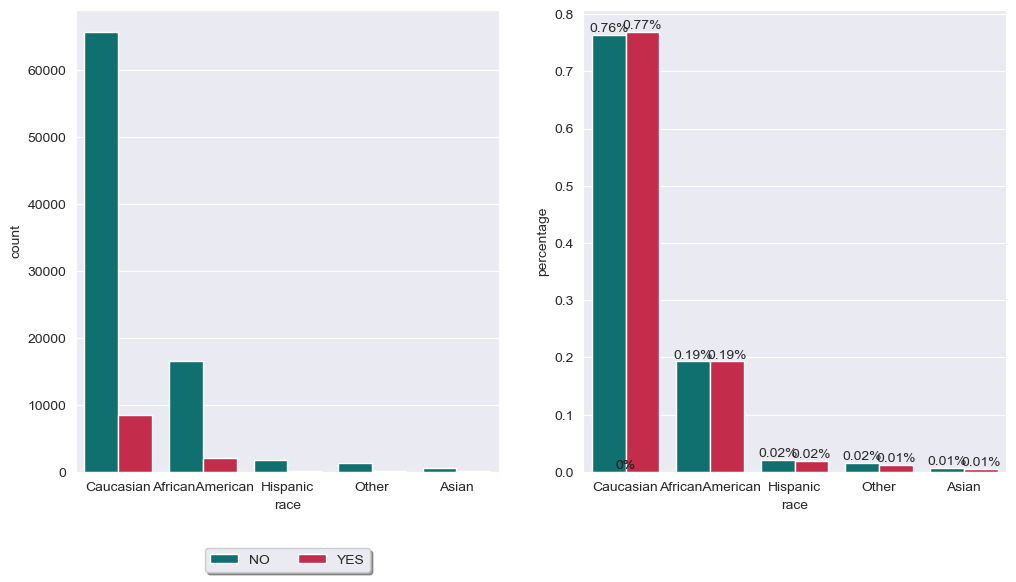

In [59]:
x = 'race'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

In [60]:
race_reduse = dt.CategoryGroupOthers({'race': ['AfricanAmerican', 'Caucasian']})
race_reduse.prop_setter = prop_setter
df = race_reduse.transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

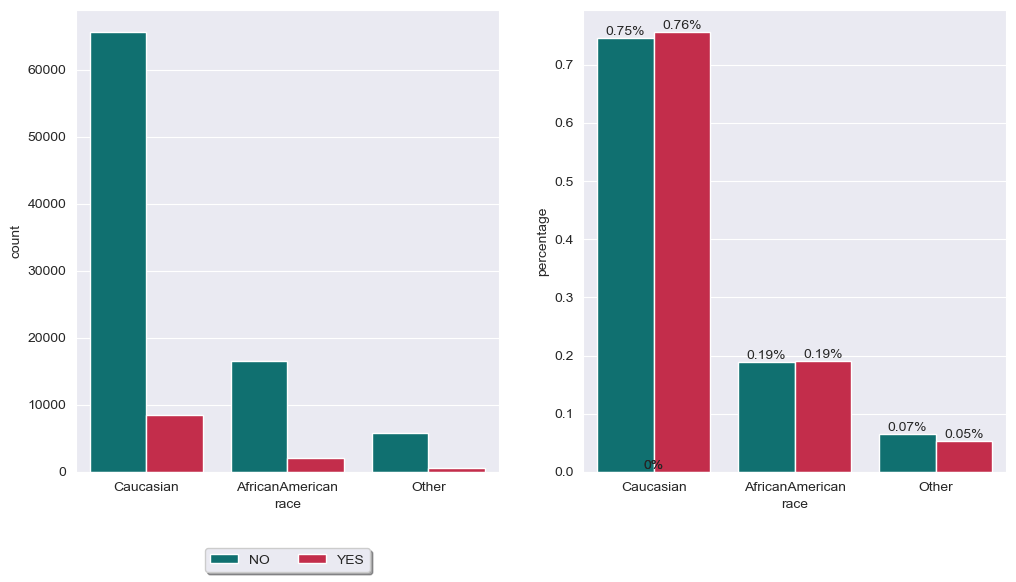

In [61]:
x = 'race'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.7 inspect age

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

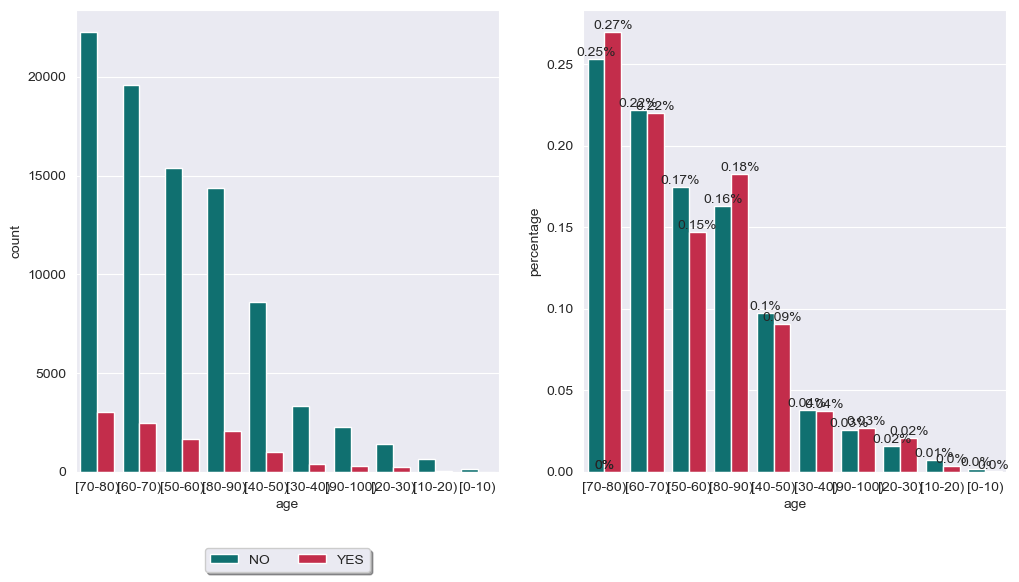

In [62]:
x = 'age'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 5.5 Adding engineered features based on time we are adding int type average for age
this gices us ordered age based on numeric values

In [63]:

mean_age =dt.AddFeatureAverageAge(age_group_col='age')
mean_age.prop_setter = prop_setter
df=mean_age.transform(df)

In [64]:
lookup={'<30': ['[0-10)', '[10-20)', '[20-30)'], '30<60': ['[30-40)', '[40-50)', '[50-60)'], '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
age_reducer = dt.CategoryReducer(feature='age', lookup=lookup)
age_reducer.prop_setter = prop_setter
age_reducer._fit(df)
df= age_reducer.transform(df)

CategoryReducer(feature='age',
                lookup={'30<60': ['[30-40)', '[40-50)', '[50-60)'],
                        '<30': ['[0-10)', '[10-20)', '[20-30)'],
                        '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']})

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

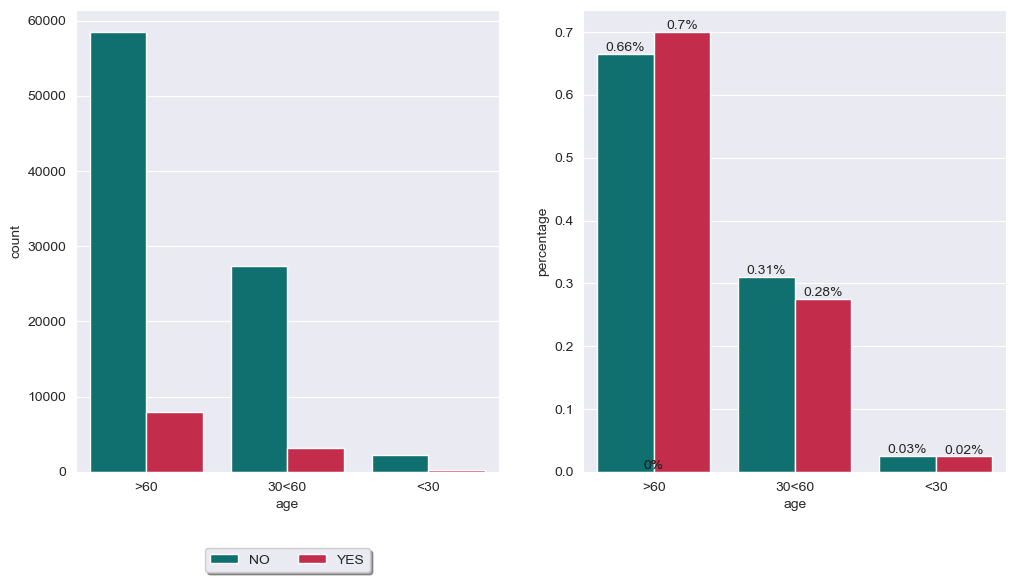

In [65]:
x = 'age'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.8 inspect medical_specialty

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

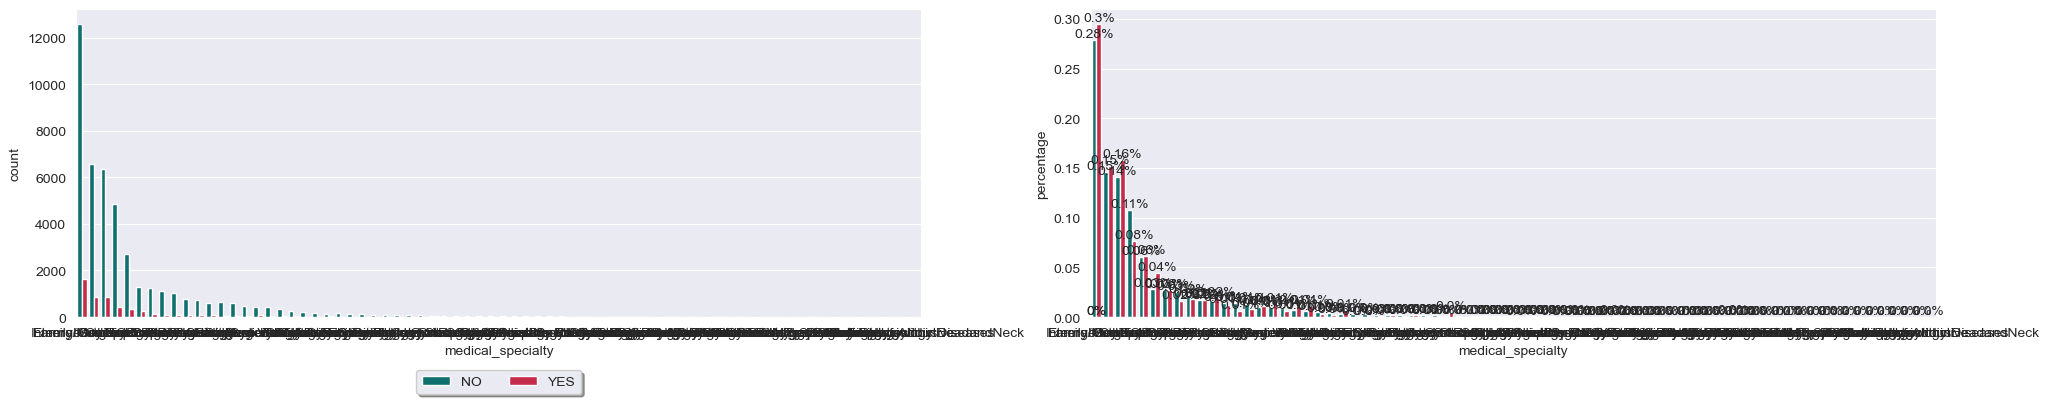

In [66]:
x = 'medical_specialty'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24, 4))

In [67]:
medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})
medical_spec_reduse.prop_setter = prop_setter
medical_spec_reduse._fit(df)
df = medical_spec_reduse.transform(df)

CategoryGroupOthers(nonother={'medical_specialty': ['InternalMedicine',
                                                    'Emergency/Trauma',
                                                    'Family/GeneralPractice',
                                                    'Cardiology',
                                                    'Surgery-General',
                                                    'Nephrology',
                                                    'Orthopedics']})

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

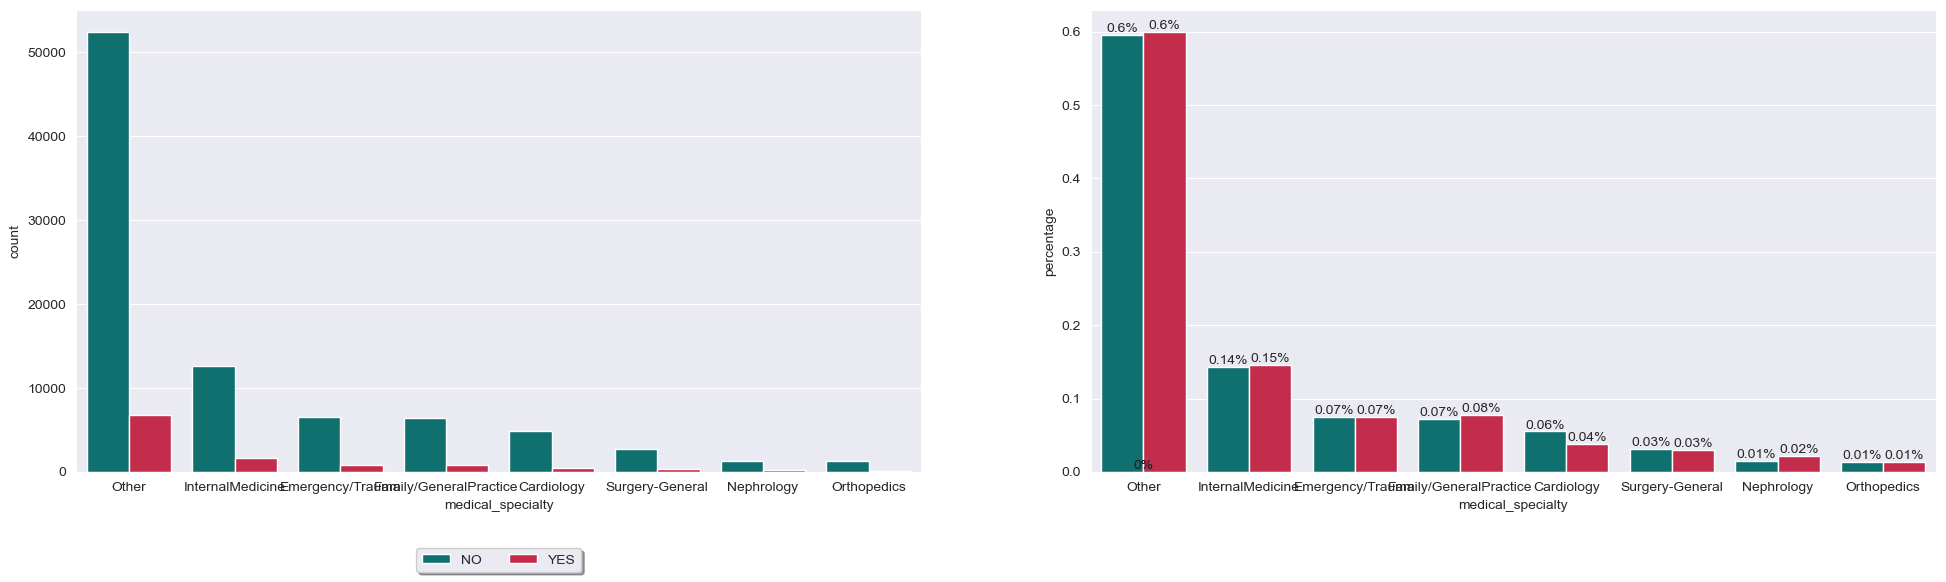

In [68]:
x = 'medical_specialty'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24, 6))

# 5. Feature Engineering

From going over the data we found multiple data editing that can be beneficial:
1. 'encounter_id' and 'patient_nbr' are identifiers and not variables
2.  'admission_type_id', 'discharge_disposition_id', and 'admission_source_id': are numerical, They should be considered categorical.
3.  'examide' and 'citoglipton' have only one unique value thus, not contributing ('No' and 'No') and removed
4.  'acetohexamide',  'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' in all this columns we find two unique values, but one value is in 99.99 percent of the data, we thus remove this columns 
5. following 4 we dicided to remove all coloumns that 95 percent or more is jest one value : ['examide', 'citoglipton', 'acetohexamide', 'tolbutamide','troglitazone', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','glipizide-metformin', 'tolazamide', 'glyburide-metformin','acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
'repaglinide']
6.there are 913 diagnostics, to reduse the dimentinalety we unite codeons based on the  major classification of it, we mannaged to reduse the diag to 19 and we changed it to be catagorical
7. gender to categorical: male, female, we removed unknown only 3
8. We changed the discharge to home/other and changed to categorical
9. addmition_id is changed to categorical, with 3 catagories 'clinic referral', 'high_prayority and other
10. race is cahnged to categorical,  nan values are turned to missing and we unite low repits values (asian and hispanic) with other
11. 6.  


## 5.1 set encounters

If you have diabetes, an ideal HbA1c level is 48mmol/mol (6.5%) or below. If you're at risk of developing type 2 diabetes,
 your target HbA1c level should be below 42mmol/mol (6%)


We considered four groups of encounters: 

(1) no HbA1c test performed.

(2) HbA1c performed and in normal range.

(3) HbA1c performed and the result is greater than 7% with no change in diabetic medications.

(4) HbA1c performed, result is greater than 7%, and diabetic medication was changed.


C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

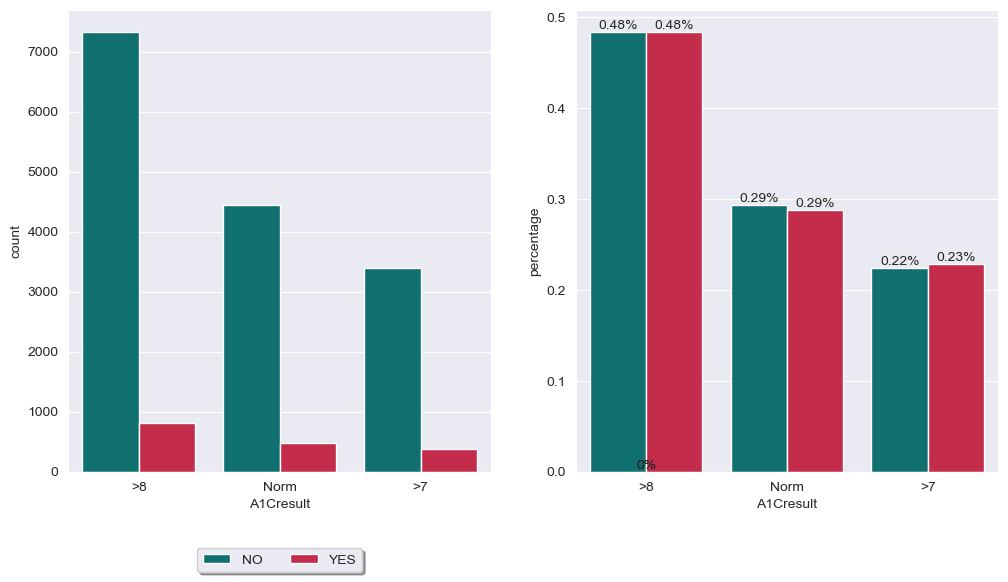

In [69]:
x = 'A1Cresult'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

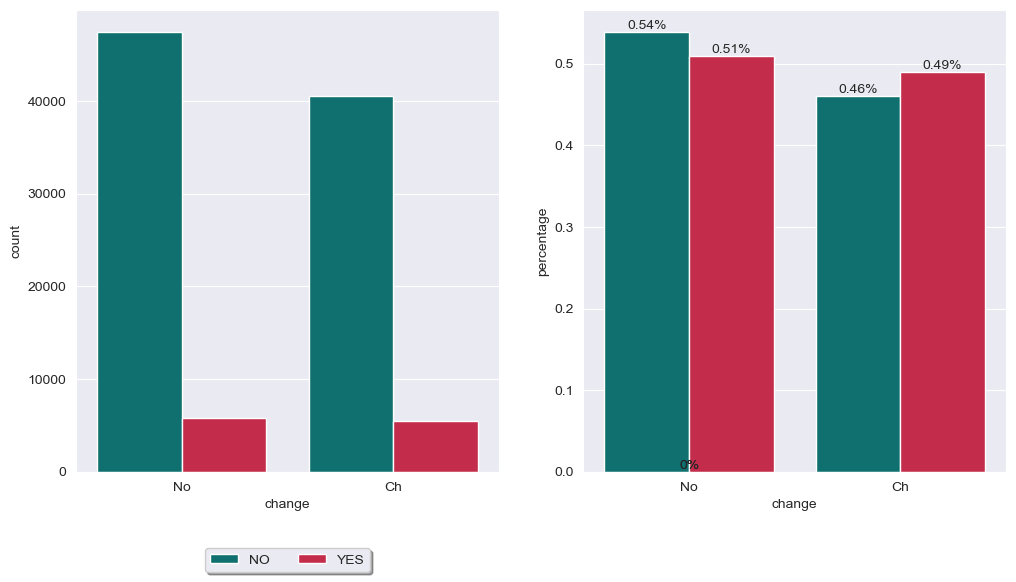

In [70]:
x = 'change'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

In [71]:
add_encounters = dt.AddFeatureEncounter()
add_encounters.prop_setter = prop_setter
df= add_encounters.transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

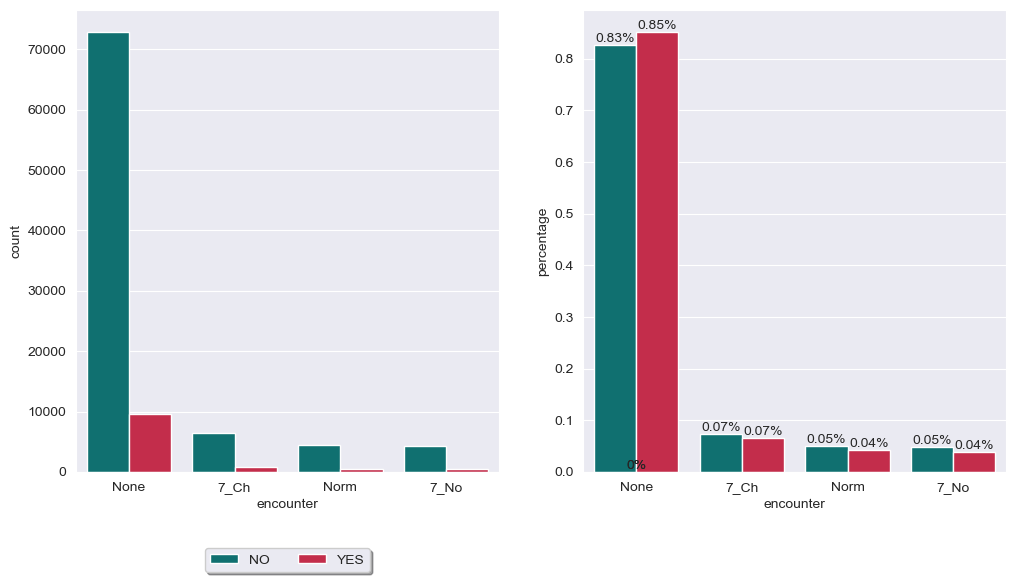

In [72]:
x = 'encounter'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 5.2 add features by summing
we want to add two features:
1. num_visits = sum(['number_outpatient', 'number_inpatient', 'number_emergency'],)
2. 'num_nonEm_visits': ['number_outpatient', 'number_inpatient']



"We are adding these features because we believe that people who tend to go to hospitals will have a higher chance of readmitting more frequentl."


In [73]:
featuers_to_sum = {
        'num_visits': ['number_outpatient', 'number_inpatient', 'number_emergency'],
        'num_nonEm_visits': ['number_outpatient', 'number_inpatient'],
    }
add_featurs_by_suming = dt.AddFeatureBySumming(featuers_to_sum)
add_featurs_by_suming.prop_setter = prop_setter
df= add_featurs_by_suming.transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_visits', ylabel='Percent'>

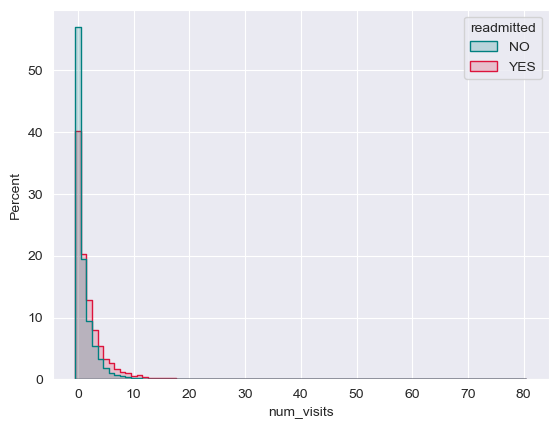

In [74]:
sns.histplot( x='num_visits', data=df, shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_nonEm_visits', ylabel='Percent'>

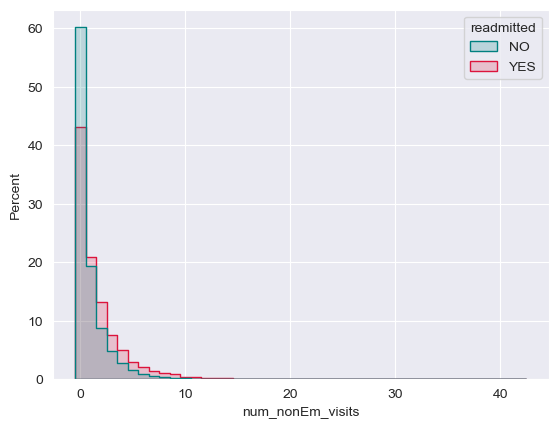

In [75]:
sns.histplot( x='num_nonEm_visits', data=df, shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

In [76]:
#  we can see that patioants with more visits tend to readdmit more

## 5.3 add_features.by_normalize
pationts lab_procedures, and medications are the total number in the encunter, we would like to normelize it by time:
to get the "perday" values:


In [77]:
add_per_day_noem = dt.AddFeatureByNormalizing({
        'time_in_hospital': (['num_lab_procedures', 'num_procedures', 'num_medications'], 'perDay')
    })
add_per_day_noem.prop_setter = prop_setter
df= add_per_day_noem.transform(df)


C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'readmitted')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'readmitted')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'readmitted')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_lab_procedures_perDay', ylabel='Percent'>

Text(0.5, 1.0, 'readmitted')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_procedures_perDay', ylabel='Percent'>

Text(0.5, 1.0, 'readmitted')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_medications_perDay', ylabel='Percent'>

Text(0.5, 1.0, 'readmitted')

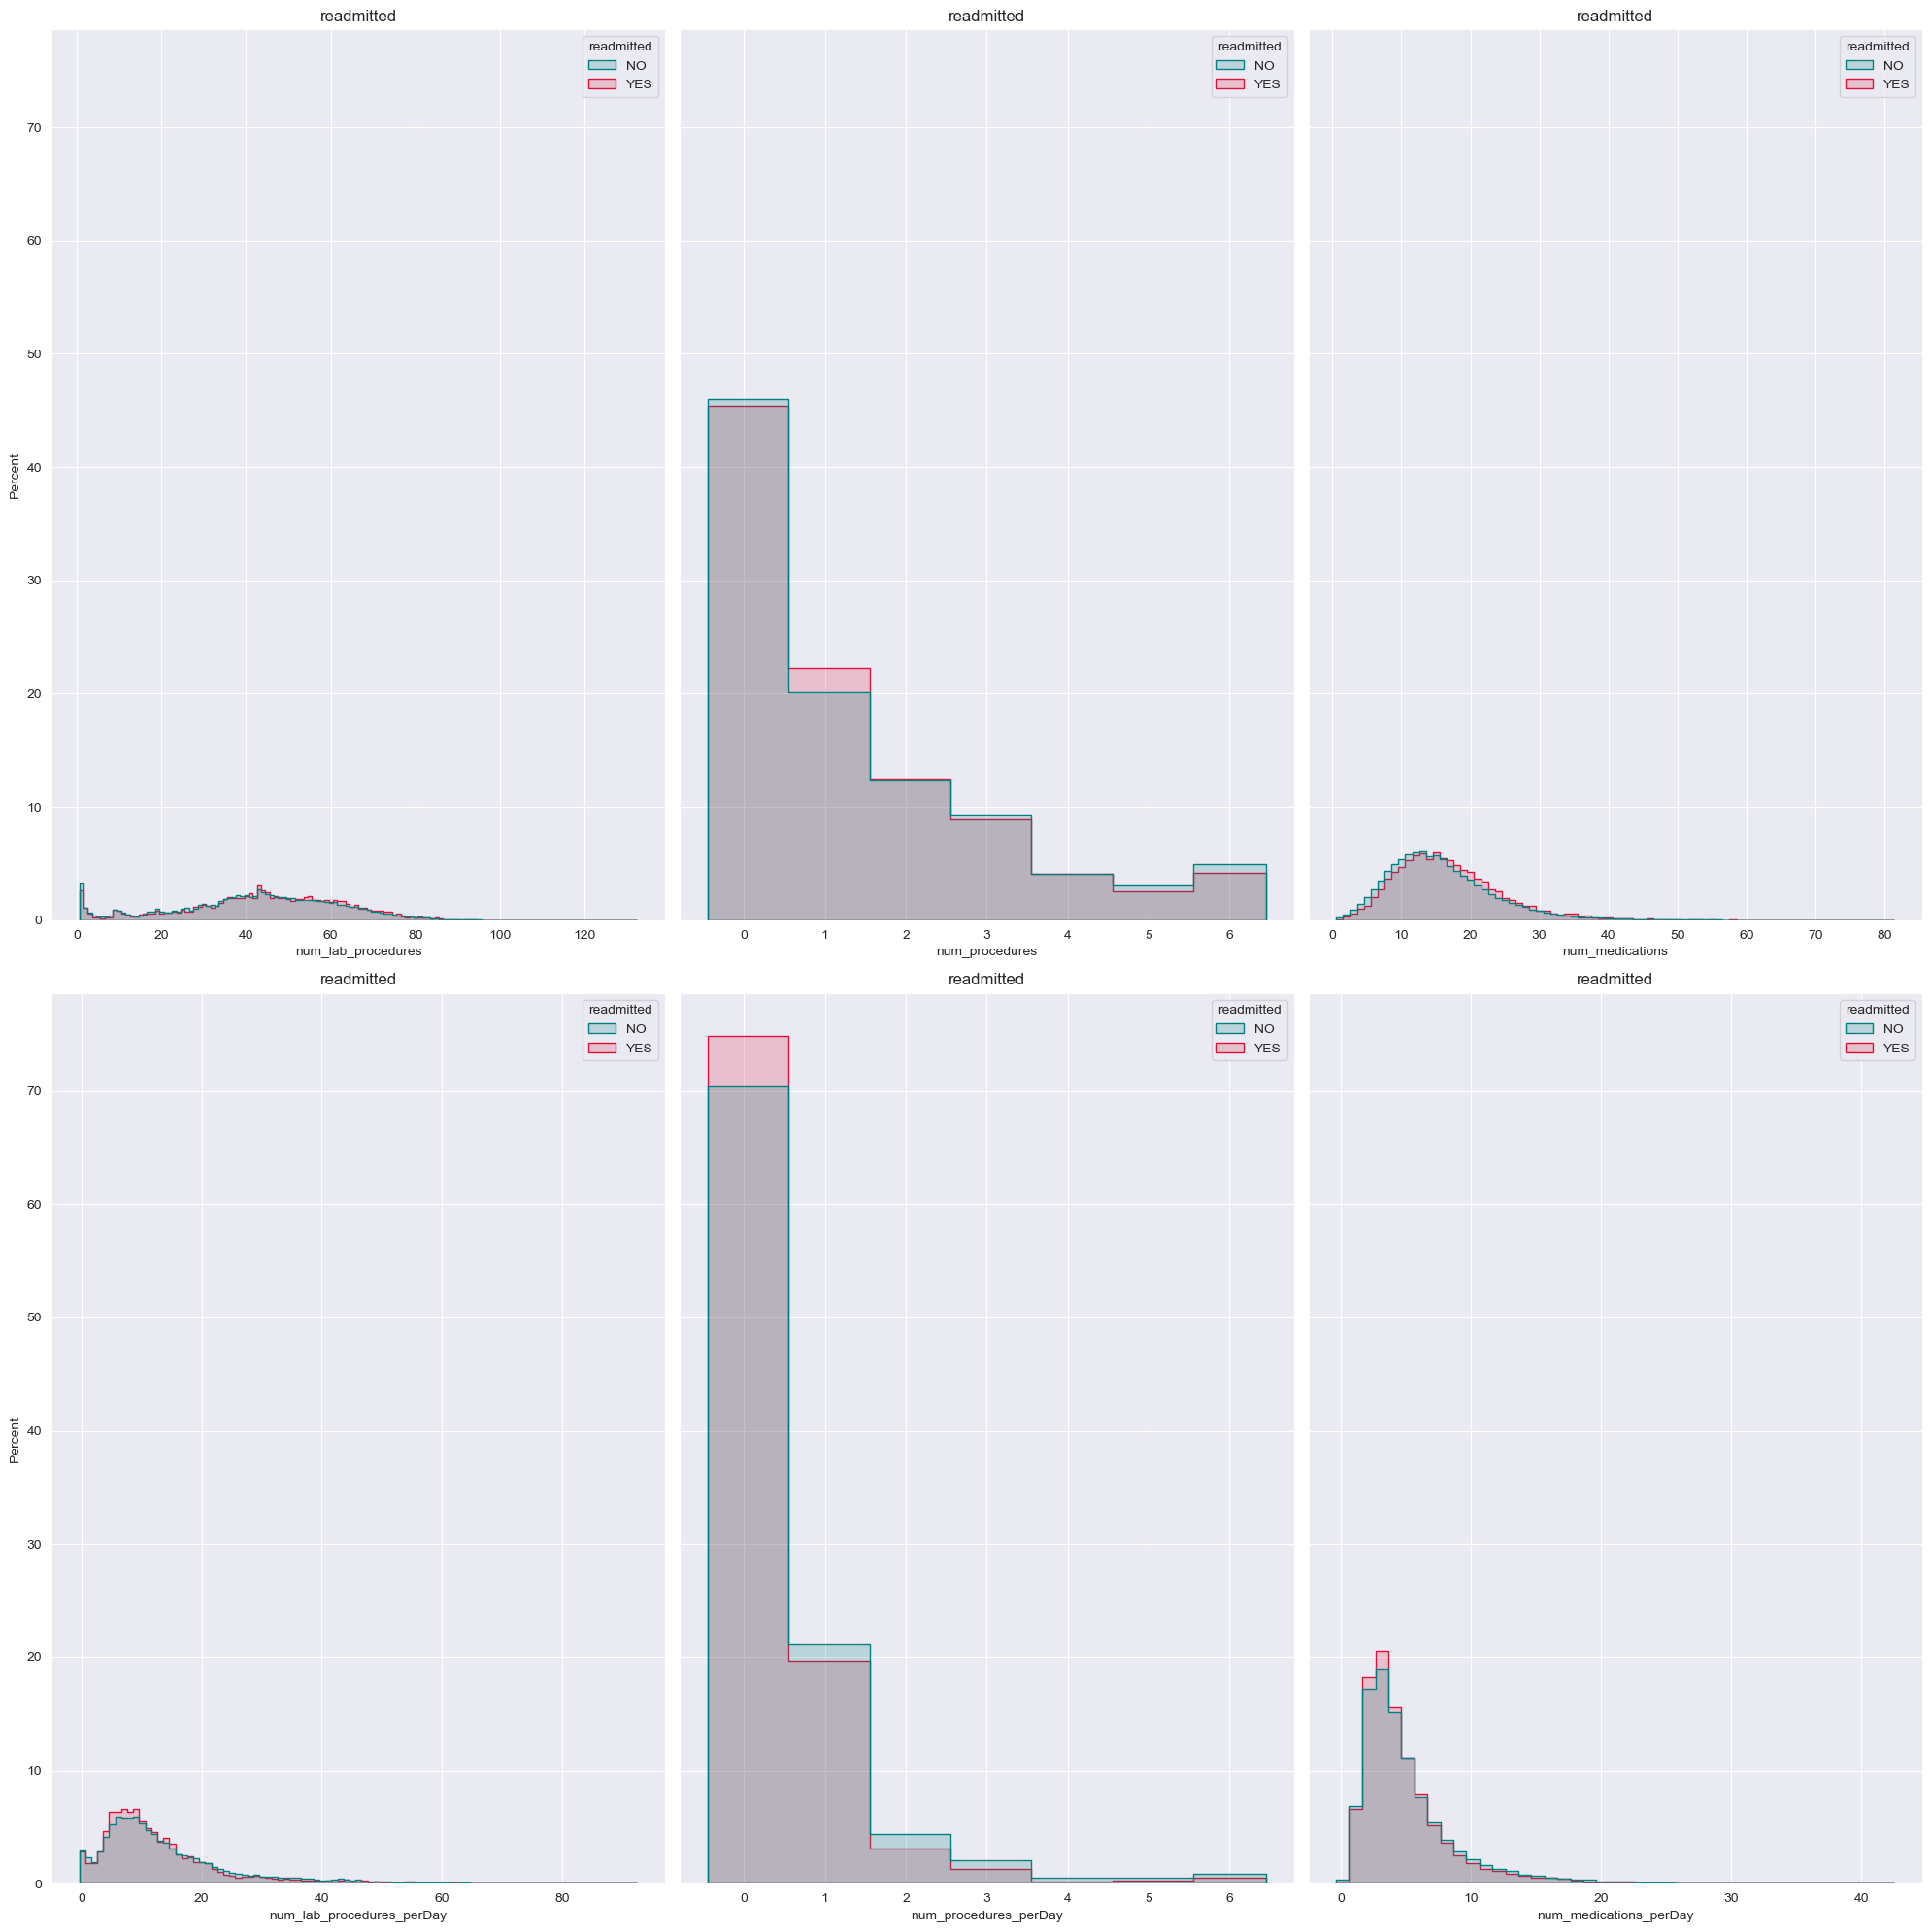

In [78]:
# let's look at the numerical data, we compare readmitted and not readmitted patients. we are looking at the percents so we can see if the distributions are different.
features = ['num_lab_procedures', 'num_procedures', 'num_medications', 'num_lab_procedures_perDay', 'num_procedures_perDay', 'num_medications_perDay']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, featur in enumerate(features):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=featur, data=df, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [79]:
# when normelizing it seems that readmmited pationts got less lof everiting per a day

In [80]:
df.keys()

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed',
       'readmitted', 'biguanides_and_related',
       'sulfonylureas_and_meglitinides',
       'thiazolidinediones_and_miscellaneous', 'number_diabetic_famalies',
       'age_avg', 'encounter', 'num_visits', 'num_nonEm_visits',
       'num_lab_procedures_perDay', 'num_procedures_perDay',
       'num_medications_perDay'],
      dtype='object')

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

<Axes: xlabel='num_nonEm_visits', ylabel='Percent'>

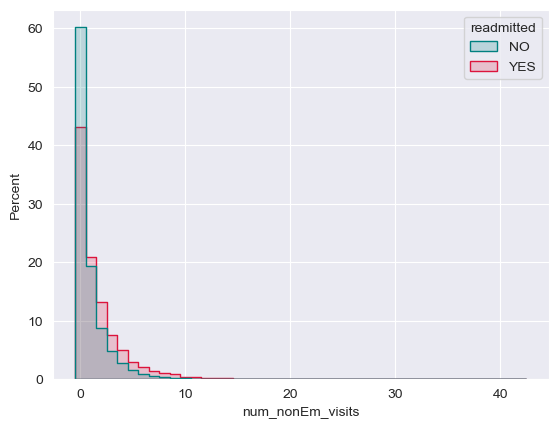

In [81]:
sns.histplot( x='num_nonEm_visits', data=df, shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

## 5.4 inspect diag 

In [82]:
df_categorical

race  gender      age  admission_type_id  \
0            Caucasian  Female   [0-10)                  6   
1            Caucasian  Female  [10-20)                  1   
2      AfricanAmerican  Female  [20-30)                  1   
3            Caucasian    Male  [30-40)                  1   
4            Caucasian    Male  [40-50)                  1   
...                ...     ...      ...                ...   
99338  AfricanAmerican    Male  [70-80)                  1   
99339  AfricanAmerican  Female  [80-90)                  1   
99340        Caucasian    Male  [70-80)                  1   
99341        Caucasian  Female  [80-90)                  2   
99342        Caucasian    Male  [70-80)                  1   

       discharge_disposition_id  admission_source_id  \
0                            25                    1   
1                             1                    7   
2                             1                    7   
3                             1                    7   
4                             1                    7   
...                         ...                  ...   
99338                         3                    7   
99339                         4                    5   
99340                         1                    7   
99341                         3                    7   
99342                         1                    7   

              medical_specialty  diag_1  diag_2 diag_3 max_glu_serum  \
0      Pediatrics-Endocrinology  250.83     NaN    NaN           NaN   
1                           NaN     276  250.01    255           NaN   
2                           NaN     648     250    V27           NaN   
3                           NaN       8  250.43    403           NaN   
4                           NaN     197     157    250           NaN   
...                         ...     ...     ...    ...           ...   
99338                       NaN  250.13     291    458           NaN   
99339                       NaN     560     276    787           NaN   
99340                       NaN      38     590    296           NaN   
99341           Surgery-General     996     285    998           NaN   
99342                       NaN     530     530    787           NaN   

      A1Cresult insulin change diabetesMed readmitted  
0           NaN      No     No          No         NO  
1           NaN      Up     Ch         Yes         NO  
2           NaN      No     No         Yes         NO  
3           NaN      Up     Ch         Yes         NO  
4           NaN  Steady     Ch         Yes         NO  
...         ...     ...    ...         ...        ...  
99338        >8    Down     Ch         Yes         NO  
99339       NaN  Steady     No         Yes         NO  
99340       NaN    Down     Ch         Yes         NO  
99341       NaN      Up     Ch         Yes         NO  
99342       NaN      No     No          No         NO  

[99343 rows x 16 columns]

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

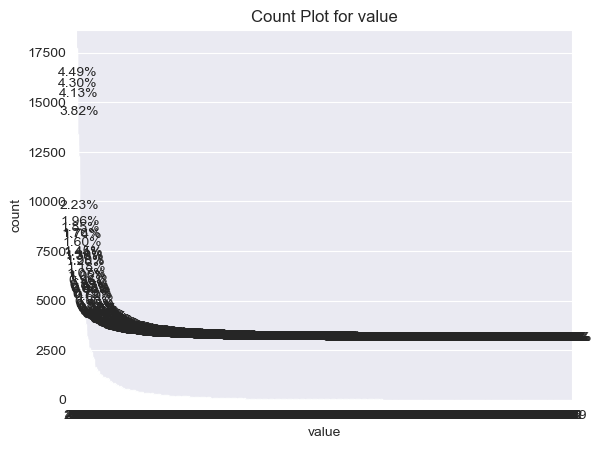

In [83]:
# we have 3 coloumns that are basicly thesame diag_1, diag_2, and diag_3: we decided to turn it to unite and turn it to categorical featurs 
diag = df.reset_index().melt(id_vars='encounter', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
# diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')

ICD-9-CM stands for the International Classification of Diseases, Ninth Revision, Clinical Modification. It is a system of codes used for classifying diseases and health conditions. The ICD-9-CM was used in the United States until it was replaced by ICD-10-CM on October 1, 2015. Despite its replacement, ICD-9-CM codes may still be found in historical medical records.

Each ICD-9-CM code is alphanumeric and consists of up to five digits. Here's a breakdown of how to read the codes:

First Digit (Numeric): The first digit represents the category of the disease or condition.

Second and Third Digits (Numeric): These digits further specify the cause, location, severity, and type of the condition within the category.

Fourth and Fifth Digits (Alphanumeric): These digits provide additional detail, such as etiology, anatomical site, or a specific condition.

For example, consider the ICD-9-CM code 401.9:

401: This is the category code for hypertensive heart disease.
.9: These digits provide additional specificity. In this case, ".9" indicates that the code is unspecified, meaning it does not provide further detail about the type or severity of hypertensive heart disease.
In the ICD-9-CM coding system, the first digit of a code represents a broad category or major classification of diseases or conditions. The first digit is numeric, and it falls into one of the following general categories:

1. 001–139: Infectious and Parasitic Disease2. s 140–239: Neoplasms (Tumor3. s) 240–279: Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disord4. ers 280–289: Diseases of the Blood and Blood-Forming Or5. gans 290–319: Mental Diso6. rders 320–389: Diseases of the Nervous System and Sense 7. Organs 390–459: Diseases of the Circulatory8. System 460–519: Diseases of the Respirator9. y System 520–579: Diseases of the Digesti10. ve System 580–629: Diseases of the Genitourin11. ary System 630–679: Complications of Pregnancy, Childbirth, and the12. Puerperium 680–709: Diseases of the Skin and Subcuta13. neous Tissue 710–739: Diseases of the Musculoskeletal System and Conn14. ective Tissue 740–759: Congen15. ital Anomalies 760–779: Certain Conditions Originating in the P16. erinatal Period 780–799: Symptoms, Signs, and Ill-De17. fined Conditions 800–999: Inj18. uoisoning E800–E999: Supplementary Classification of External Causes of In19. V: codes are used for factors influencing health status and contact with health services. These codes cover a broad range of circumstances that may not be classified as diseases but are relevant to healthcare encounters. heth servicesjury and Poisoning

if we are looking at the unique values we are seeing a lot of variation, dou to unique case in digits 4 and 5 in the code, lets change then we will unite al desises that are in the same catagory it to the first three digits only. we will take only diagnostics that are in 2.5 percent or more in the cases and we will remove '250' becuse all pationt are diabitic

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

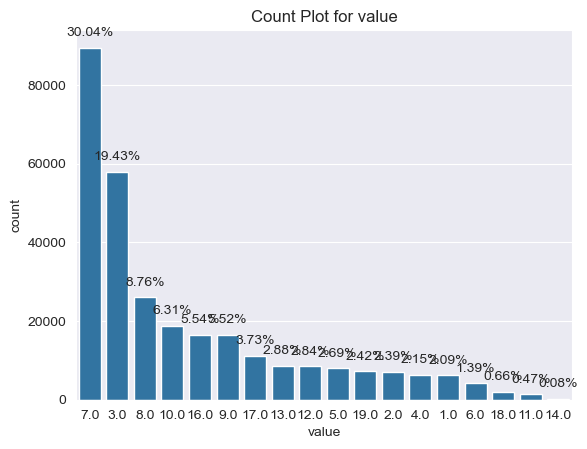

In [84]:
# lokking at the diag data we find two probloms
# 1. high number of fetuers,
# 2. uneven number of diag between patiants
# here we unite the diag based on the ICD-9-CM coding system into groups
# *each patiant can have more then one option

# df_categorical.reset_index()
# daig = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')




def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan


diag = df.reset_index().melt(id_vars='encounter', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')
# diag = pd.get_dummies(diag, columns=['value'], prefix='daig_').groupby('encounter_id').sum()

# diag=diag>0
# diag.astype(int).sum(axis=0)/len(diag) *100

# df_with_diag = pd.concat([df_witout_bed_columns.set_index('encounter_id'), diag], axis=1)
# df_with_diag.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


In [85]:
df

patient_nbr             race  gender    age admission_type_id  \
0          8222157        Caucasian  Female    <30             Other   
1         55629189        Caucasian  Female    <30             HighP   
2         86047875  AfricanAmerican  Female    <30             HighP   
3         82442376        Caucasian    Male  30<60             HighP   
4         42519267        Caucasian    Male  30<60             HighP   
...            ...              ...     ...    ...               ...   
99335    100162476  AfricanAmerican    Male    >60             HighP   
99336     74694222  AfricanAmerican  Female    >60             HighP   
99337     41088789        Caucasian    Male    >60             HighP   
99338     31693671        Caucasian  Female    >60             HighP   
99339    175429310        Caucasian    Male    >60             HighP   

      discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        Other                    1                 1   
1                         home                    7                 3   
2                         home                    7                 2   
3                         home                    7                 2   
4                         home                    7                 1   
...                        ...                  ...               ...   
99335                    Other                    7                 3   
99336                    Other                    5                 5   
99337                     home                    7                 1   
99338                    Other                    7                10   
99339                     home                    7                 6   

      medical_specialty  num_lab_procedures  ...  \
0                 Other                  41  ...   
1                 Other                  59  ...   
2                 Other                  11  ...   
3                 Other                  44  ...   
4                 Other                  51  ...   
...                 ...                 ...  ...   
99335             Other                  51  ...   
99336             Other                  33  ...   
99337             Other                  53  ...   
99338   Surgery-General                  45  ...   
99339             Other                  13  ...   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
0                                   0                                     0   
1                                   0                                     0   
2                                   1                                     0   
3                                   0                                     0   
4                                   1                                     0   
...                               ...                                   ...   
99335                               0                                     0   
99336                               0                                     0   
99337                               0                                     0   
99338                               1                                     1   
99339                               0                                     0   

       number_diabetic_famalies  age_avg  encounter num_visits  \
0                             0        5       None          0   
1                             0       15       None          0   
2                             1       25       None          3   
3                             0       35       None          0   
4                             1       45       None          0   
...                         ...      ...        ...        ...   
99335                         1       75       7_Ch          0   
99336                         0       85       None          1   
99337                         1       75       None          1   
99338                         2

In [86]:
# Assuming 'change_value' is a function that transforms the values based on the type
def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan



def change_diag_to_type(row):
    diag_1 = change_value(row['diag_1'])
    diag_2 = change_value(row['diag_2'])
    diag_3 = change_value(row['diag_3'])  
    return pd.Series([diag_1, diag_2, diag_3], index=['diag_1', 'diag_2', 'diag_3'])

# Apply the function to each row and create new columns
df[['diag_1', 'diag_2', 'diag_3']] = df.apply(change_diag_to_type, axis=1)
# df.apply(change_diag_to_type, axis=1)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

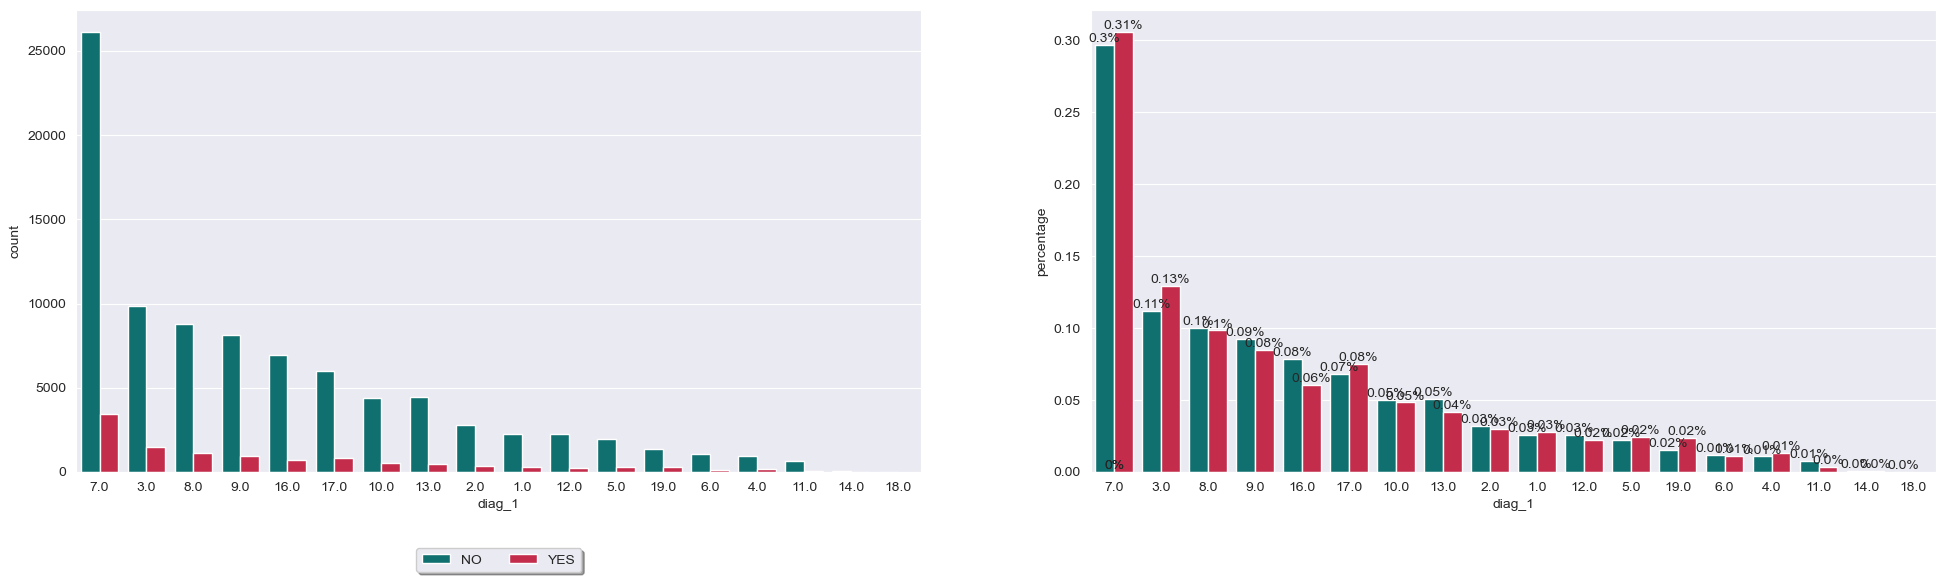

In [87]:
x = 'diag_1'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24,6))

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

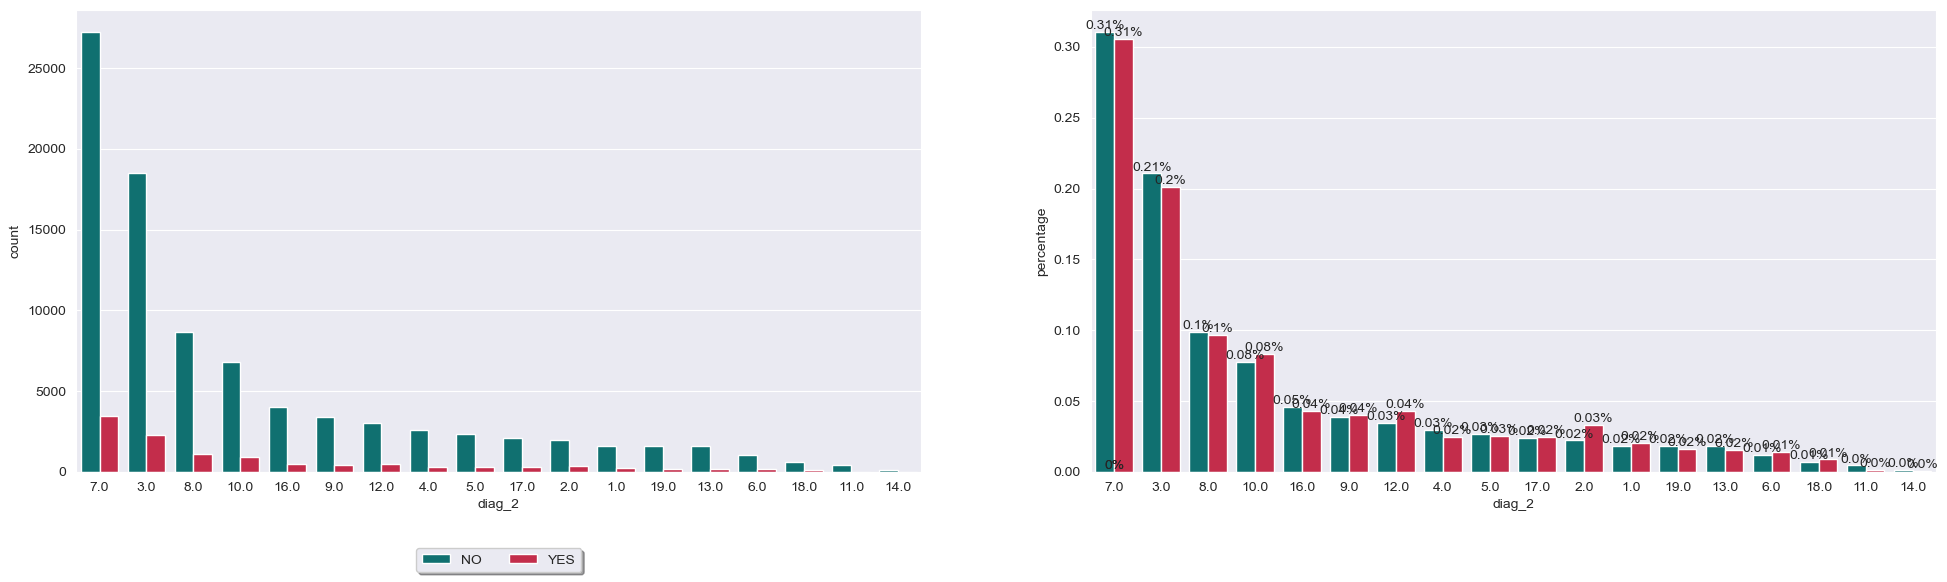

In [88]:
x = 'diag_2'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24,6))

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

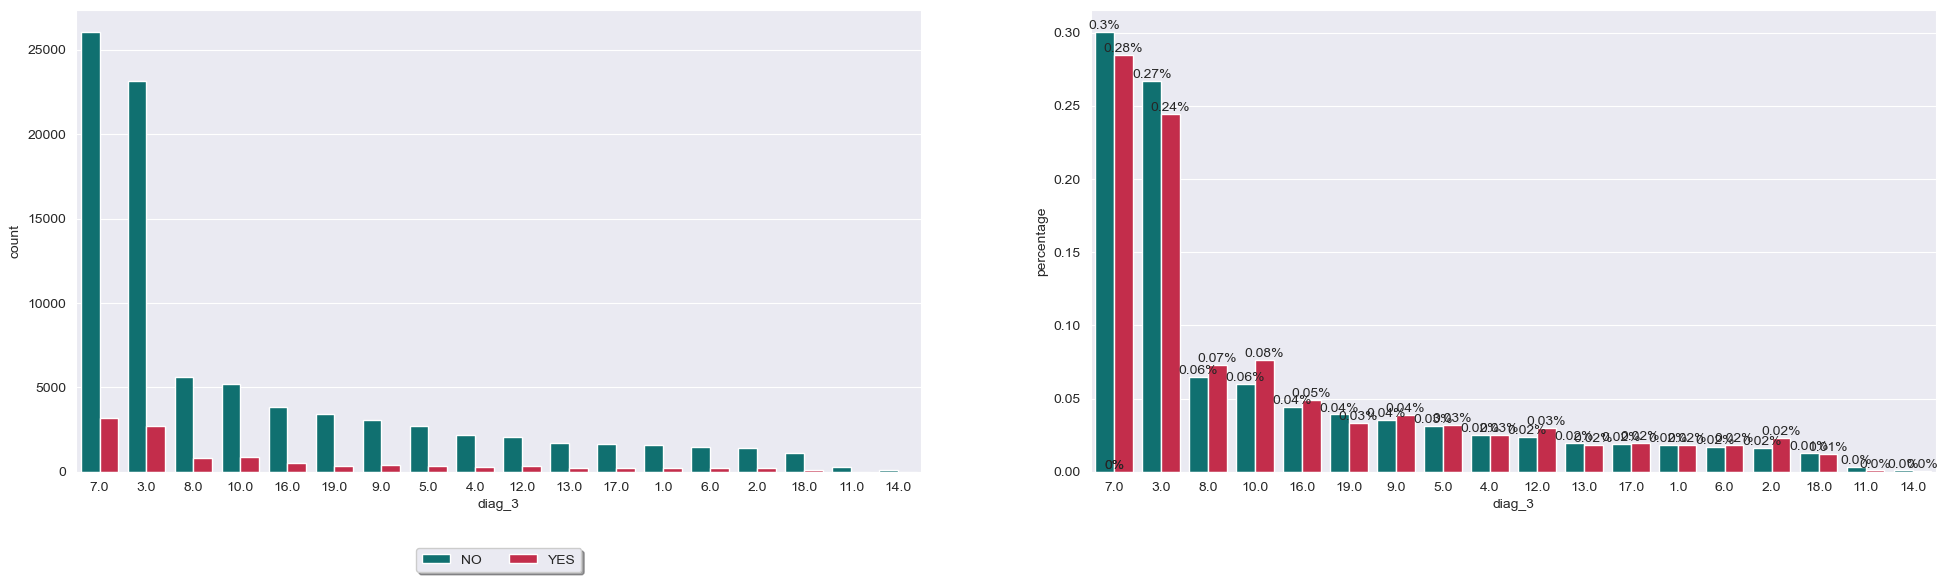

In [89]:
x = 'diag_3'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24,6))

# 6. Split test and validation 

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(result_df, test_size=0.2, random_state=42, stratify=result_df['readmitted'])

In [ ]:
plot_categorical_with_percent(test_set, column='readmitted')

In [ ]:
plot_categorical_with_percent(train_set, column='readmitted')

In [ ]:
train = train_set.drop("readmitted", axis=1) # drop labels for training set
train_labels = train_set["readmitted"].copy()

In [ ]:
cat_columns = df_categorical.drop(columns=['readmitted']).keys()

In [ ]:
df_categorical = df_categorical.drop(columns=['readmitted'])

In [ ]:
df_categorical.info()

In [591]:
import data

In [593]:
import config

In [594]:
data.load_data(config)

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)    NaN   
1             149190     55629189        Caucasian  Female  [10-20)    NaN   
2              64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3             500364     82442376        Caucasian    Male  [30-40)    NaN   
4              16680     42519267        Caucasian    Male  [40-50)    NaN   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)    NaN   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)    NaN   
101763     443854148     41088789        Caucasian    Male  [70-80)    NaN   
101764     443857166     31693671        Caucasian  Female  [80-90)    NaN   
101765     443867222    175429310        Caucasian    Male  [70-80)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

In [596]:
data.build_data_prep_pipe(config)

TypeError: 'module' object is not subscriptable

In [597]:
df

patient_nbr             race  gender    age admission_type_id  \
0          8222157        Caucasian  Female    <30             Other   
1         55629189        Caucasian  Female    <30             HighP   
2         86047875  AfricanAmerican  Female    <30             HighP   
3         82442376        Caucasian    Male  30<60             HighP   
4         42519267        Caucasian    Male  30<60             HighP   
...            ...              ...     ...    ...               ...   
99335    100162476  AfricanAmerican    Male    >60             HighP   
99336     74694222  AfricanAmerican  Female    >60             HighP   
99337     41088789        Caucasian    Male    >60             HighP   
99338     31693671        Caucasian  Female    >60             HighP   
99339    175429310        Caucasian    Male    >60             HighP   

      discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        Other                    1                 1   
1                         home                    7                 3   
2                         home                    7                 2   
3                         home                    7                 2   
4                         home                    7                 1   
...                        ...                  ...               ...   
99335                    Other                    7                 3   
99336                    Other                    5                 5   
99337                     home                    7                 1   
99338                    Other                    7                10   
99339                     home                    7                 6   

      medical_specialty  num_lab_procedures  ...  \
0                 Other                  41  ...   
1                 Other                  59  ...   
2                 Other                  11  ...   
3                 Other                  44  ...   
4                 Other                  51  ...   
...                 ...                 ...  ...   
99335             Other                  51  ...   
99336             Other                  33  ...   
99337             Other                  53  ...   
99338   Surgery-General                  45  ...   
99339             Other                  13  ...   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
0                                   0                                     0   
1                                   0                                     0   
2                                   1                                     0   
3                                   0                                     0   
4                                   1                                     0   
...                               ...                                   ...   
99335                               0                                     0   
99336                               0                                     0   
99337                               0                                     0   
99338                               1                                     1   
99339                               0                                     0   

       number_diabetic_famalies  age_avg  encounter  num_visits  \
0                             0        5       None           0   
1                             0       15       None           0   
2                             1       25       None           3   
3                             0       35       None           0   
4                             1       45       None           0   
...                         ...      ...        ...         ...   
99335                         1       75       7_Ch           0   
99336                         0       85       None           1   
99337                         1       75       None           1   
99338                

In [ ]:
def make_prepped_csv(config: Dict):

    folder = paths.DATA_PATH / "prepped"
    folder.mkdir(parents=True, exist_ok=True)
    print("Making prepped data csvs")

    csv_name = f"prepped_data {get_hash(get_section(config, 'data'))[:6]}"

    raw_data = load_data(config)
    prep_pipe = build_data_prep_pipe(config)
    Xy = prep_pipe.fit_transform(raw_data)

    df = pd.concat(Xy, axis=1)
    df.to_csv(folder / (csv_name + " NonStandardized.csv"))

    standardizer = Standardizer(**config['data.standardize'])
    Xy = standardizer.fit_transform(Xy)

    df = pd.concat(Xy, axis=1)
    df.to_csv(folder / (csv_name + " Standardized.csv"))
    print("Done. Saved to: " + str(folder))

In [99]:
r_df = data.make_prepped_csv(config.get_base_config())

Making prepped data csvs
Data prep pipe:
 (0) RowRemoverByFeatureValue[discharge_disposition_id] -> (1) RowRemoverByFeatureValue[gender]
 -> (2) RowRemoverByDuplicates[patient_nbr] -> (3) AddFeatureByNormalizing -> (4) AddFeatureBySumming
 -> (5) AddFeatureByCounting -> (6) AddFeatureBySumming[nnz] -> (7) AddFeatureAverageAge
 -> (8) AddFeatureEncounter -> (9) CategoryReducer[readmitted] -> (10) CategoryReducer[age]
 -> (11) CategoryReducer[admission_type_id] -> (12) CategoryReducer[discharge_disposition_id]
 -> (13) CategoryGroupOthers -> (14) ICDConverter -> (15) PropertySetter -> (16) TargetSeparator

Done. Saved to: C:\Users\dekel\Desktop\ml_project\240418\ml-2024\data\prepped


In [100]:
r_df = pd.DataFrame.read

In [93]:
df

patient_nbr             race  gender    age admission_type_id  \
0          8222157        Caucasian  Female    <30             Other   
1         55629189        Caucasian  Female    <30             HighP   
2         86047875  AfricanAmerican  Female    <30             HighP   
3         82442376        Caucasian    Male  30<60             HighP   
4         42519267        Caucasian    Male  30<60             HighP   
...            ...              ...     ...    ...               ...   
99335    100162476  AfricanAmerican    Male    >60             HighP   
99336     74694222  AfricanAmerican  Female    >60             HighP   
99337     41088789        Caucasian    Male    >60             HighP   
99338     31693671        Caucasian  Female    >60             HighP   
99339    175429310        Caucasian    Male    >60             HighP   

      discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        Other                    1                 1   
1                         home                    7                 3   
2                         home                    7                 2   
3                         home                    7                 2   
4                         home                    7                 1   
...                        ...                  ...               ...   
99335                    Other                    7                 3   
99336                    Other                    5                 5   
99337                     home                    7                 1   
99338                    Other                    7                10   
99339                     home                    7                 6   

      medical_specialty  num_lab_procedures  ...  \
0                 Other                  41  ...   
1                 Other                  59  ...   
2                 Other                  11  ...   
3                 Other                  44  ...   
4                 Other                  51  ...   
...                 ...                 ...  ...   
99335             Other                  51  ...   
99336             Other                  33  ...   
99337             Other                  53  ...   
99338   Surgery-General                  45  ...   
99339             Other                  13  ...   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
0                                   0                                     0   
1                                   0                                     0   
2                                   1                                     0   
3                                   0                                     0   
4                                   1                                     0   
...                               ...                                   ...   
99335                               0                                     0   
99336                               0                                     0   
99337                               0                                     0   
99338                               1                                     1   
99339                               0                                     0   

       number_diabetic_famalies  age_avg  encounter  num_visits  \
0                             0        5       None           0   
1                             0       15       None           0   
2                             1       25       None           3   
3                             0       35       None           0   
4                             1       45       None           0   
...                         ...      ...        ...         ...   
99335                         1       75       7_Ch           0   
99336                         0       85       None           1   
99337                         1       75       None           1   
99338                

In [97]:
import data
import config

In [95]:
data

<module 'data' from 'C:\\Users\\dekel\\Desktop\\ml_project\\240418\\ml-2024\\data.py'>

In [105]:
df.drop_duplicates('patient_nbr')

patient_nbr             race  gender    age admission_type_id  \
0          8222157        Caucasian  Female    <30             Other   
1         55629189        Caucasian  Female    <30             HighP   
2         86047875  AfricanAmerican  Female    <30             HighP   
3         82442376        Caucasian    Male  30<60             HighP   
4         42519267        Caucasian    Male  30<60             HighP   
...            ...              ...     ...    ...               ...   
99328    183087545        Caucasian  Female    >60             HighP   
99329    188574944            Other  Female  30<60             HighP   
99330    140199494            Other  Female    >60             HighP   
99332    120975314        Caucasian  Female    >60             HighP   
99339    175429310        Caucasian    Male    >60             HighP   

      discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        Other                    1                 1   
1                         home                    7                 3   
2                         home                    7                 2   
3                         home                    7                 2   
4                         home                    7                 1   
...                        ...                  ...               ...   
99328                     home                    7                 9   
99329                     home                    7                14   
99330                     home                    7                 2   
99332                     home                    7                 5   
99339                     home                    7                 6   

      medical_specialty  num_lab_procedures  ...  \
0                 Other                  41  ...   
1                 Other                  59  ...   
2                 Other                  11  ...   
3                 Other                  44  ...   
4                 Other                  51  ...   
...                 ...                 ...  ...   
99328             Other                  50  ...   
99329             Other                  73  ...   
99330             Other                  46  ...   
99332             Other                  76  ...   
99339             Other                  13  ...   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
0                                   0                                     0   
1                                   0                                     0   
2                                   1                                     0   
3                                   0                                     0   
4                                   1                                     0   
...                               ...                                   ...   
99328                               1                                     0   
99329                               1                                     0   
99330                               0                                     0   
99332                               0                                     0   
99339                               0                                     0   

       number_diabetic_famalies  age_avg  encounter  num_visits  \
0                             0        5       None           0   
1                             0       15       None           0   
2                             1       25       None           3   
3                             0       35       None           0   
4                             1       45       None           0   
...                         ...      ...        ...         ...   
99328                         1       75       7_Ch           0   
99329                         1       45       7_Ch           1   
99330                         0       65       None           3   
99332                

In [106]:
prossesed_data

race  gender    age admission_type_id  \
0            Caucasian  Female    <30             Other   
1            Caucasian  Female    <30             HighP   
2      AfricanAmerican  Female    <30             HighP   
3            Caucasian    Male  30-60             HighP   
4            Caucasian    Male  30-60             HighP   
...                ...     ...    ...               ...   
69982        Caucasian  Female    >60             HighP   
69983            Other  Female  30-60             HighP   
69984            Other  Female    >60             HighP   
69985        Caucasian  Female    >60             HighP   
69986        Caucasian    Male    >60             HighP   

      discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        Other                    1               1.0   
1                         Home                    7               3.0   
2                         Home                    7               2.0   
3                         Home                    7               2.0   
4                         Home                    7               1.0   
...                        ...                  ...               ...   
69982                     Home                    7               9.0   
69983                     Home                    7              14.0   
69984                     Home                    7               2.0   
69985                     Home                    7               5.0   
69986                     Home                    7               6.0   

      medical_specialty  num_lab_procedures  num_procedures  ...  \
0                 Other                41.0             0.0  ...   
1                 Other                59.0             0.0  ...   
2                 Other                11.0             5.0  ...   
3                 Other                44.0             1.0  ...   
4                 Other                51.0             0.0  ...   
...                 ...                 ...             ...  ...   
69982             Other                50.0             2.0  ...   
69983             Other                73.0             6.0  ...   
69984             Other                46.0             6.0  ...   
69985             Other                76.0             1.0  ...   
69986             Other                13.0             3.0  ...   

       num_medications_perDay  num_visits  num_nonEm_visits  \
0                    1.000000         0.0               0.0   
1                    6.000000         0.0               0.0   
2                    6.500000         3.0               3.0   
3                    8.000000         0.0               0.0   
4                    8.000000         0.0               0.0   
...                       ...         ...               ...   
69982                3.666667         0.0               0.0   
69983                1.857143         1.0               0.0   
69984                8.500000         3.0               2.0   
69985                4.400000         1.0               0.0   
69986                0.500000         0.0               0.0   

       biguanides_and_related  sulfonylureas_and_meglitinides  \
0                         0.0                             0.0   
1                         0.0                             0.0   
2                         0.0                             1.0   
3                         0.0                             0.0   
4                         0.0                             1.0   
...                       ...                             ...   
69982                     0.0                             1.0   
69983                     0.0                             1.0   
69984                     0.0                             0.0   
69985                     0.0                             0.0   
69986                     0.0                             0.0   

       thiazolidinediones_and_miscellaneous  num_med_groups  age_avg  \
0    